<a href="https://colab.research.google.com/github/genaiconference/RAG_Workshop_DHS2024/blob/main/04_Advanced_RAG_Retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Retrieval-Augmented Generation (RAG): LangChain Implementation
This Notebook implements an advanced RAG system with the following components
* How to handle **multiple data sources**
* Showcases the power of various **Advanced Retrievers**

In [1]:
!git clone https://github.com/genaiconference/RAG_Workshop_DHS2024.git

Cloning into 'RAG_Workshop_DHS2024'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 60 (delta 14), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (60/60), 29.28 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
!pip install -r /content/RAG_Workshop_DHS2024/rag_requirements.txt

## Imports

In [27]:
import os
import time
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from RAG_Workshop_DHS2024.utils import pretty_print_result, pretty_print_docs

## Azure - Model & Embeddings Configuration
Define relevant environment variables in a .env file

In [5]:
# if directly using open ai api key
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_type = "openai"

## Step1: Document Loading
Load 4 documents - 2022 & 2023 Annual Reports of Apple and Microsoft

In [6]:
from langchain.document_loaders import DirectoryLoader, PyPDFLoader

loader = DirectoryLoader('/content/RAG_Workshop_DHS2024/data/Annual Reports', glob="**/*.pdf", loader_cls = PyPDFLoader, use_multithreading=True)
documents = loader.load()
print(len(documents))

240


## Step2: Document Splitting

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunkByWord(text):
    return len(text.split(" "))

text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, length_function = chunkByWord, chunk_overlap=50, add_start_index = False)

docs = text_splitter.split_documents(documents)

print(len(docs))

366


## Step3: Vectorstores & Embeddings

In [40]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

# Direct open ai way
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')

# Azure open ai way
# embeddings = OpenAIEmbeddings(deployment=EMBEDDING_DEPLOYMENT_NAME,
#                               openai_api_key=EMBEDDING_API_KEY,
#                               openai_api_base=EMBEDDING_API_BASE,
#                               openai_api_version=API_VERSION,
#                               openai_api_type=API_TYPE,
#                               chunk_size=1)

In [41]:
## save to disk
vectorstore = Chroma.from_documents(documents=docs, embedding=embeddings, persist_directory='vectorstore/annual_reports/')

## load from disk
# vectorstore = Chroma(persist_directory='vectorstore/annual_reports/',embedding_function=embeddings)

In [42]:
from langchain.chat_models import AzureChatOpenAI, ChatOpenAI

# Open AI way
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)

# # Azure Open AI way
# llm = AzureChatOpenAI(
#         openai_api_base=API_BASE,
#         openai_api_version=API_VERSION,
#         deployment_name=GPT4_TURBO_DEPLOYMENT_NAME,
#         openai_api_key=API_KEY,
#         openai_api_type=API_TYPE,
#         temperature=0
#     )

## Step4: Retrieval

### Type1 - LOTR (Merger Retriever) - Handling multiple retrievers
Lord of the Retrievers, also known as MergerRetriever, takes a list of retrievers as input and merges the results of their get_relevant_documents() methods into a single list. The merged results will be a list of documents that are relevant to the query and that have been ranked by the different retrievers.

The MergerRetriever class can be used to improve the accuracy of document retrieval in a number of ways. First, it can combine the results of multiple retrievers, which can help to reduce the risk of bias in the results. Second, it can rank the results of the different retrievers, which can help to ensure that the most relevant documents are returned first.

In [34]:
from langchain.retrievers import MergerRetriever, BM25Retriever

# Define 2 diff retrievers with 2 diff search type.
retriever_1 = vectorstore.as_retriever(search_type="similarity",
                                                 search_kwargs={"k": 5, "include_metadata": True}
                                                )

# retriever_2 = vectorstore.as_retriever(search_type="mmr",
#                                                  search_kwargs={"k": 5, "include_metadata": True}
#                                                 )

# BM25 Retriver for keyword based retrieval using BM25 algorithm
bm25_retriever = BM25Retriever.from_documents(docs)

bm25_retriever.k = 3 # set the num of docs to be retrieved

# Hybrid Retriver using Semantic Search and Keyword search together
lotr = MergerRetriever(retrievers=[retriever_1, bm25_retriever])

In [35]:
from RAG_Workshop_DHS2024.utils import *

In [36]:
def pretty_print_result(query, _llm, retriever):
    """
    Custom function to print clean output
    """
    chain = ConversationalRetrievalChain.from_llm(llm=_llm,
                                           combine_docs_chain_kwargs={"prompt": RAG_prompt},
                                          retriever=retriever,
                                           memory=memory,
                                           return_source_documents=True)
    try:
      result = chain({"question": query})
      display(Markdown("Answer: " + result["answer"].replace('$','`$`')))
      print("No of documents retrieved: " + str(len(result['source_documents'])))
      print("=============================================================================================================")
      display(Markdown(f"\n{'-.' * 100}\n\n".join([f"Document {i+1}:\n\n" + d.page_content.replace('$','`$`') +"\n\n" + str(d.metadata) for i, d in enumerate(result['source_documents'])])))
    except Exception as e:
        print(e)
        pass
    return


In [37]:
query = "Compare the Revenue trends of Microsoft between the years 2022 and 2023?"
pretty_print_result(query, llm, lotr)

Answer: Microsoft's revenue trends between 2022 and 2023 show an overall increase of 7%, rising from `$`198.27 billion in 2022 to `$`211.92 billion in 2023. The Intelligent Cloud segment experienced a significant revenue increase of `$`12.9 billion or 17%, with server products and cloud services revenue growing by `$`12.6 billion or 19%, primarily driven by Azure and other cloud services, which grew by 29%. The Productivity and Business Processes segment also saw a revenue increase of 9%, while the More Personal Computing segment experienced a decline of 9%.

No of documents retrieved: 8


Document 1:

respectively.  
Intelligent Cloud  
Revenue increased  `$`12.9  billion or 17%. 
• Server products and cloud services revenue increased `$` 12.6 billion or 19% driven by Azure and other cloud 
services. Azure and other cloud services revenue grew 29% driven by  growth in our consumption -based 
services. Server products revenue decreased 1% . 
• Enterprise Services revenue increased `$` 315 million or 4% driven by growth in Enterprise Support Services, 
offset in part by a decline in Industry Solutions (formerly Microsoft Consulting Services ).

{'page': 41, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

Apple Inc.
Notes to Consolidated Financial Statements
Note 1 – 
Summary of Significant Accounting Policies
Basis of Presentation and Preparation
The consolidated ﬁnancial statements include the accounts of Apple Inc. and its wholly owned subsidiaries (collectively “Apple” or the “Company”). Intercompany
accounts and transactions have been eliminated. The preparation of these consolidated ﬁnancial statements and accompanying notes in conformity with U.S.
generally accepted accounting principles requires management to make estimates and assumptions that aﬀect the amounts reported. Actual results could diﬀer
materially from those estimates. Certain prior period amounts in the consolidated ﬁnancial statements and accompanying notes have been reclassiﬁed to conform to
the current period’s presentation.
The Company’s ﬁscal year is the 52- or 53-week period that ends on the last Saturday of September. An additional week is included in the ﬁrst ﬁscal quarter every
ﬁve or six years to realign the Company’s ﬁscal quarters with calendar quarters, which will occur in the ﬁrst quarter of the Company’s ﬁscal year ending September
30, 2023. The Company’s ﬁscal years 2022, 2021 and 2020 spanned 52 weeks each. Unless otherwise stated, references to particular years, quarters, months and
periods refer to the Company’s fiscal years ended in September and the associated quarters, months and periods of those fiscal years.
Revenue Recognition
Net sales consist of revenue from the sale of iPhone, Mac, iPad, Services and other products. The Company recognizes revenue at the amount to which it expects to
be entitled when control of the products or services is transferred to its customers. Control is generally transferred when the Company has a present right to payment
and title and the signiﬁcant risks and rewards of ownership of products or services are transferred to its customers. For most of the Company’s Products net sales,
control transfers when products are shipped. For the Company’s Services net sales, control transfers over time as services are delivered. Payment for Products and
Services net sales is collected within a short period following transfer of control or commencement of delivery of services, as applicable.
The Company records reductions to Products net sales related to future product returns, price protection and other customer incentive programs based on the
Company’s expectations and historical experience.
For arrangements with multiple performance obligations, which represent promises within an arrangement that are distinct, the Company allocates revenue to all
distinct performance obligations based on their relative stand-alone selling prices (“SSPs”). When available, the Company uses observable prices to determine SSPs.
When observable prices are not available, SSPs are established that reﬂect the Company’s best estimates of what the selling prices of the performance obligations
would be if they were sold regularly on a stand-alone basis. The Company’s process for estimating SSPs without observable prices considers multiple factors that may
vary depending upon the unique facts and circumstances related to each performance obligation including, where applicable, prices charged by the Company for
similar offerings, market trends in the pricing for similar offerings, product-specific business objectives and the estimated cost to provide the performance obligation.
The Company has identiﬁed up to 
three
 performance obligations regularly included in arrangements involving the sale of iPhone, Mac, iPad and certain other
products. The ﬁrst performance obligation, which represents the substantial portion of the allocated sales price, is the hardware and bundled software delivered at the
time of sale. The second performance obligation is the right to receive certain product-related bundled services, which include iCloud
, Siri
 and Maps. The third
performance obligation is the right to receive, on a when-and-if-available basis, future unspeciﬁed software upgrades relating to the software bundled with each
device. The Company allocates revenue and any related discounts to these performance obligations based on their relative SSPs. Because the Company lacks
observable prices for the undelivered performance obligations, the allocation of revenue is based on the Company’s estimated SSPs. Revenue allocated to the

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf', 'page': 37}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

respectively.  
Intelligent Cloud  
Revenue increased  `$`12.9  billion or 17%. 
• Server products and cloud services revenue increased `$` 12.6 billion or 19% driven by Azure and other cloud 
services. Azure and other cloud services revenue grew 29% driven by  growth in our consumption -based 
services. Server products revenue decreased 1% . 
• Enterprise Services revenue increased `$` 315 million or 4% driven by growth in Enterprise Support Services, 
offset in part by a decline in Industry Solutions (formerly Microsoft Consulting Services ).

{'page': 41, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

PART II  
Item 7 
 
44 Fiscal Year 2023 Compared with Fiscal Year 2022  
Interest and dividends income increased due to higher yields, offset in part by lower portfolio balances. Interest expense 
decreased due to a decrease in  outstanding long -term debt due to debt maturities. Net recognized gains on 
investments decreased due to lower gains on equity securities and higher losses on fixed income securities. Net losses 
on derivatives increased due to losses related to managing st rategic investments.  
INCOME TAXES  
Effective Tax Rate  
Our effective tax rate for fiscal years 2023  and 2022  was 19% and 1 3%, respectively . The increase in our effective tax 
rate was primarily due to a `$`3.3 billion net income tax benefit in the first quarter of fiscal year 2022 related to the trans fer 
of intangible properties and a decrease in tax benefits relating to stock -based compensation.  
In the first quarter of fiscal year 2022, we transferred certain intangible properties from our Puerto Rico subsidiary to 
the U.S. The transfer of intangible properties resulted in a `$`3.3 billion net income tax benefit in the first quarter of fisc al 
year 2 022, as the value of future U.S. tax deductions exceeded the current tax liability from the U.S. global intangible 
low-taxed income tax.  
Our effective tax rate was lower than the U.S. federal statutory rate, primarily due to earnings taxed at lower rates in 
foreign jurisdictions resulting from producing and distributing our products and services through our foreign regional 
operations center in Ireland.  
The mix of income before income taxes between the U.S. and foreign countries impacted our effective tax rate as a 
result of the geographic distribution of, and customer demand for, our products and services. In fiscal year 2023 , our 
U.S. income before income taxes was `$` 52.9 billion and our foreign income before income taxes was `$` 36.4 billion. In 
fiscal year 2022, our U.S. income before income taxes was `$`47.8 billion and our foreign income before income taxes 
was `$`35.9 billion.  
Uncertain Tax Positions  
We settled a portion of the Internal Revenue Service (“IRS”) audit for tax years 2004 to 2006 in fiscal year 2011. In 
February 2012, the IRS withdrew its 2011 Revenue Agents Report related to unresolved issues for tax years 2004 to 
2006 and reopened the audit  phase of the examination. We also settled a portion of the IRS audit for tax years 2007 
to 2009 in fiscal year 2016, and a portion of the IRS audit for tax years 2010 to 2013 in fiscal year 2018. In the second 
quarter of fiscal year 2021, we settled an  additional portion of the IRS audits for tax years 2004 to 2013 and made a 
payment of `$`1.7 billion, including tax and interest. We remain under audit for tax years 2004 to 2017.  
As of  June 30, 2023 , the primary unresolved issues for the  IRS audits relate  to transfer pricing, which could have a 
material impact in our consolidated financial statements when the matters are resolved. We believe our allowances for 
income tax contingencies are adequate . We have not received a proposed assessment for the unresolved key transfer 
pricing issues. We do not expect a final resolution of these issues in the next 12 months.  Based on the information 
currently available, we do not anticipate a significant increase or decrease to our tax contingencies for these issues 
within the next 12 months.  
We are subject to income tax in many jurisdictions outside the U.S. Our operations in certain jurisdictions remain

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 44}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 5:

PART II  
Item 8  
91 No sales to an individual customer or country other than the United States accounted for more than 10% of revenue 
for fiscal years 2023 , 2022 , or 2021 . Revenue, classified by the major geographic areas in which our customers were 
located, was as follows:  
 
(In millions)           
     
Year Ended June  30,    2023     2022     2021   
    
United States  (a)   `$` 106,744      `$` 100,218      `$` 83,953    
Other countries      105,171        98,052        84,135    
                 
             
Total    `$` 211,915     `$` 198,270      `$` 168,088    
                       
(a) Includes billings to OEMs and certain multinational organizations because of the nature of these businesses and 
the impracticability of determining the geographic source of the revenue.  
Revenue, classified by significant product and service offerings, was as follows:   
 
(In millions)           
     
Year Ended June  30,    2023     2022     2021   
    
Server products and cloud services     `$` 79,970     `$` 67,350     `$` 52,589    
Office products and cloud services     48,728       44,862       39,872   
Windows      21,507       24,732       22,488    
Gaming     15,466   
    16,230   
    15,370    
LinkedIn    15,145     13,816     10,289    
Search and news advertising      12,208        11,591        9,267    
Enterprise Services    7,722     7,407     6,943   
Devices    5,521     7,306     7,143   
Dynamics    5,437     4,687     3,754   
Other       211       289       373   
              
                
Total    `$` 211,915     `$` 198,270      `$` 168,088

{'page': 91, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 6:

PART II  
Item 7 
 
48 transaction  subject to obtaining required regulatory approvals and satisfaction of other customary closing conditions.  
Microsoft and Activision Blizzard have jointly agreed to extend the merger agreement through  October 18, 2023 to 
allow for additional time to resolve remaining regulatory concerns.  
We will continue to invest in sales, marketing, product support infrastructure, and existing and advanced areas of 
technology, as well as acquisitions that align with our business strategy. Additions to property and equipment will 
continue, including new f acilities, datacenters, and computer systems for research and development, sales and 
marketing, support, and administrative staff. We expect capital expenditures to increase in coming years to support 
growth in our cloud offerings and our investments in AI infrastructure. We have operating and finance leases for 
datacenters, corporate offices, research and development facilities, Microsoft Experience Centers, and certain 
equipment. We have not engaged in any related party transactions or arrangements with u nconsolidated entities or 
other persons that are reasonably likely to materially affect liquidity or the availability of capital resources.  
CRITICAL ACCOUNTING ESTIMATES  
Our consolidated financial statements and accompanying notes are prepared in accordance with GAAP. Preparing 
consolidated financial statements requires management to make estimates and assumptions that affect the reported 
amounts of assets, liabilities, re venue, and expenses. Critical accounting estimates are those estimates that involve a 
significant level of estimation uncertainty and could have a material impact on our financial condition or results of 
operations. We have critical accounting estimates in  the areas of revenue recognition, impairment of investment 
securities, goodwill, research and development costs, legal and other contingencies, income taxes, and inventories.  
Revenue Recognition  
Our contracts with customers often include promises to transfer multiple products and services to a customer. 
Determining whether products and services are considered distinct performance obligations that should be accounted 
for separately versus together may require significant judgment. When a cloud -based service includes both on -
premises software licenses and cloud services, judgment is required to determine whether the software license is 
considered distinct and accounted for separately, or not distinct  and accounted for together with the cloud service and 
recognized over time. Certain cloud services, primarily Office 365, depend on a significant level of integration, 
interdependency, and interrelation between the desktop applications and cloud services,  and are accounted for 
together as one performance obligation. Revenue from Office 365 is recognized ratably over the period in which the 
cloud services are provided.  
Judgment is required to determine the stand -alone selling price (“SSP") for each distinct performance obligation. We  
use a single amount to estimate SSP for items that are not sold separately, including on -premises licenses sold with 
SA or  software updates provided at no additional charge.  We use a range of amounts to estimate SSP when we sell 
each of the products and services separately and need to determine whether there is a discount to be allocated based 
on the relative SSP of the various products and s ervices.  
In instances where SSP is not directly observable, such as when we do not sell the product or service separately, we 
determine the SSP using information that may include market conditions and other observable inputs. We typically 
have more than one SSP for  individual products and services due to the stratification of those products and services 
by customers and circumstances. In these instances, we may use information such as the size of the customer and 
geographic region in determining the SSP.  
 
Due to the various benefits from and the nature of our SA program, judgment is required to assess the pattern of

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 48}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 7:

PART II  
Item 8  
91 No sales to an individual customer or country other than the United States accounted for more than 10% of revenue 
for fiscal years 2023 , 2022 , or 2021 . Revenue, classified by the major geographic areas in which our customers were 
located, was as follows:  
 
(In millions)           
     
Year Ended June  30,    2023     2022     2021   
    
United States  (a)   `$` 106,744      `$` 100,218      `$` 83,953    
Other countries      105,171        98,052        84,135    
                 
             
Total    `$` 211,915     `$` 198,270      `$` 168,088    
                       
(a) Includes billings to OEMs and certain multinational organizations because of the nature of these businesses and 
the impracticability of determining the geographic source of the revenue.  
Revenue, classified by significant product and service offerings, was as follows:   
 
(In millions)           
     
Year Ended June  30,    2023     2022     2021   
    
Server products and cloud services     `$` 79,970     `$` 67,350     `$` 52,589    
Office products and cloud services     48,728       44,862       39,872   
Windows      21,507       24,732       22,488    
Gaming     15,466   
    16,230   
    15,370    
LinkedIn    15,145     13,816     10,289    
Search and news advertising      12,208        11,591        9,267    
Enterprise Services    7,722     7,407     6,943   
Devices    5,521     7,306     7,143   
Dynamics    5,437     4,687     3,754   
Other       211       289       373   
              
                
Total    `$` 211,915     `$` 198,270      `$` 168,088

{'page': 91, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 8:

PART II  
Item 7 
 
41 SEGMENT RESULTS OF OPERATIONS  
  
(In millions, except percentages)    2023     2022     Percentage  
Change    
  
  
Revenue                         
     
Productivity and Business Processes   `$` 69,274    `$` 63,364    9%  
Intelligent Cloud    87,907    74,965    17%  
More Personal Computing    54,734      59,941     (9)%  
         
                
Total    `$` 211,915     `$` 198,270      7%   
            
     
Operating Income             
            
Productivity and Business Processes   `$` 34,189   `$` 29,690   15%  
Intelligent Cloud    37,884    33,203   14%  
More Personal Computing    16,450     20,490   (20)%  
         
                
Total   `$` 88,523   `$` 83,383    6%  
            
Reportable Segments  
Fiscal Year 2023  Compared with Fiscal Year 2022   
Productivity and Business Processes  
Revenue increased  `$`5.9 billion or 9%.  
• Office Commercial products and cloud services revenue increased `$` 3.7 billion or 10%. Office 365 
Commercial revenue grew 13% with seat growth of 11%, driven by small and medium business and frontline 
worker offerings, as well as growth in revenue per user. Office Commercial products revenue declined 21% 
driven by continued customer shift to cloud offerings.  
• Office Consumer products and cloud services revenue increased `$` 140 million or 2%. Microsoft 365 
Consumer subscribers grew 12% to 67.0 million.   
• LinkedIn revenue increased `$`1. 3 billion or 10% driven by Talent Solutions.  
• Dynamics products and cloud services revenue increased `$`750 million or 16% driven by Dynamics 365 
growth of 24%. 
Operating income increased  `$`4.5 billion or 15%.  
• Gross margin increased  `$`5.8 billion or 12% driven by growth in Office 365 Commercial  and LinkedIn , as 
well as the change in accounting estimate. Gross margin percentage increased. Excluding the impact of the 
change in accounting estimate, gross margin percentage increased slightly  driven by improvement in Office 
365 Commercial, offset in part by sales mix shift to cloud offerings.  
• Operating expenses increased  `$`1.3 billion or 7% driven by investment in LinkedIn and employee severance 
expenses.  
Revenue, gross margin, and operating income included an unfavorable foreign currency impact of 5%, 5%, and 8%, 
respectively.  
Intelligent Cloud  
Revenue increased  `$`12.9  billion or 17%. 
• Server products and cloud services revenue increased `$` 12.6 billion or 19% driven by Azure and other cloud

{'page': 41, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf'}

## Type2 - Ensemble Retriever - Handling multiple retrievers
The EnsembleRetriever takes a list of retrievers as input and ensemble the results of their get_relevant_documents() methods and rerank the results based on the Reciprocal Rank Fusion algorithm.

By leveraging the strengths of different algorithms, the EnsembleRetriever can achieve better performance than any single algorithm.

In [43]:
from langchain.retrievers import EnsembleRetriever

# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(retrievers=[retriever_1, bm25_retriever], weights=[0.5, 0.5])

In [44]:
query = "Compare the Revenue trends of Microsoft between the years 2022 and 2023?"
pretty_print_result(query, llm, ensemble_retriever)

Answer: In 2023, Microsoft's total revenue increased to `$`211.9 billion, a 7% rise from `$`198.3 billion in 2022. The Intelligent Cloud segment saw a significant revenue increase of `$`12.9 billion (17%), reaching `$`87.9 billion, driven by Azure and other cloud services. Productivity and Business Processes revenue grew by `$`5.9 billion (9%) to `$`69.3 billion, while More Personal Computing revenue decreased by 9% to `$`54.7 billion. Overall, the growth in Intelligent Cloud and Productivity segments offset the decline in More Personal Computing.

No of documents retrieved: 5


Document 1:

respectively.  
Intelligent Cloud  
Revenue increased  `$`12.9  billion or 17%. 
• Server products and cloud services revenue increased `$` 12.6 billion or 19% driven by Azure and other cloud 
services. Azure and other cloud services revenue grew 29% driven by  growth in our consumption -based 
services. Server products revenue decreased 1% . 
• Enterprise Services revenue increased `$` 315 million or 4% driven by growth in Enterprise Support Services, 
offset in part by a decline in Industry Solutions (formerly Microsoft Consulting Services ).

{'page': 41, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

PART II  
Item 7 
 
41 SEGMENT RESULTS OF OPERATIONS  
  
(In millions, except percentages)    2023     2022     Percentage  
Change    
  
  
Revenue                         
     
Productivity and Business Processes   `$` 69,274    `$` 63,364    9%  
Intelligent Cloud    87,907    74,965    17%  
More Personal Computing    54,734      59,941     (9)%  
         
                
Total    `$` 211,915     `$` 198,270      7%   
            
     
Operating Income             
            
Productivity and Business Processes   `$` 34,189   `$` 29,690   15%  
Intelligent Cloud    37,884    33,203   14%  
More Personal Computing    16,450     20,490   (20)%  
         
                
Total   `$` 88,523   `$` 83,383    6%  
            
Reportable Segments  
Fiscal Year 2023  Compared with Fiscal Year 2022   
Productivity and Business Processes  
Revenue increased  `$`5.9 billion or 9%.  
• Office Commercial products and cloud services revenue increased `$` 3.7 billion or 10%. Office 365 
Commercial revenue grew 13% with seat growth of 11%, driven by small and medium business and frontline 
worker offerings, as well as growth in revenue per user. Office Commercial products revenue declined 21% 
driven by continued customer shift to cloud offerings.  
• Office Consumer products and cloud services revenue increased `$` 140 million or 2%. Microsoft 365 
Consumer subscribers grew 12% to 67.0 million.   
• LinkedIn revenue increased `$`1. 3 billion or 10% driven by Talent Solutions.  
• Dynamics products and cloud services revenue increased `$`750 million or 16% driven by Dynamics 365 
growth of 24%. 
Operating income increased  `$`4.5 billion or 15%.  
• Gross margin increased  `$`5.8 billion or 12% driven by growth in Office 365 Commercial  and LinkedIn , as 
well as the change in accounting estimate. Gross margin percentage increased. Excluding the impact of the 
change in accounting estimate, gross margin percentage increased slightly  driven by improvement in Office 
365 Commercial, offset in part by sales mix shift to cloud offerings.  
• Operating expenses increased  `$`1.3 billion or 7% driven by investment in LinkedIn and employee severance 
expenses.  
Revenue, gross margin, and operating income included an unfavorable foreign currency impact of 5%, 5%, and 8%, 
respectively.  
Intelligent Cloud  
Revenue increased  `$`12.9  billion or 17%. 
• Server products and cloud services revenue increased `$` 12.6 billion or 19% driven by Azure and other cloud

{'page': 41, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

PART II  
Item 7 
 
44 Fiscal Year 2023 Compared with Fiscal Year 2022  
Interest and dividends income increased due to higher yields, offset in part by lower portfolio balances. Interest expense 
decreased due to a decrease in  outstanding long -term debt due to debt maturities. Net recognized gains on 
investments decreased due to lower gains on equity securities and higher losses on fixed income securities. Net losses 
on derivatives increased due to losses related to managing st rategic investments.  
INCOME TAXES  
Effective Tax Rate  
Our effective tax rate for fiscal years 2023  and 2022  was 19% and 1 3%, respectively . The increase in our effective tax 
rate was primarily due to a `$`3.3 billion net income tax benefit in the first quarter of fiscal year 2022 related to the trans fer 
of intangible properties and a decrease in tax benefits relating to stock -based compensation.  
In the first quarter of fiscal year 2022, we transferred certain intangible properties from our Puerto Rico subsidiary to 
the U.S. The transfer of intangible properties resulted in a `$`3.3 billion net income tax benefit in the first quarter of fisc al 
year 2 022, as the value of future U.S. tax deductions exceeded the current tax liability from the U.S. global intangible 
low-taxed income tax.  
Our effective tax rate was lower than the U.S. federal statutory rate, primarily due to earnings taxed at lower rates in 
foreign jurisdictions resulting from producing and distributing our products and services through our foreign regional 
operations center in Ireland.  
The mix of income before income taxes between the U.S. and foreign countries impacted our effective tax rate as a 
result of the geographic distribution of, and customer demand for, our products and services. In fiscal year 2023 , our 
U.S. income before income taxes was `$` 52.9 billion and our foreign income before income taxes was `$` 36.4 billion. In 
fiscal year 2022, our U.S. income before income taxes was `$`47.8 billion and our foreign income before income taxes 
was `$`35.9 billion.  
Uncertain Tax Positions  
We settled a portion of the Internal Revenue Service (“IRS”) audit for tax years 2004 to 2006 in fiscal year 2011. In 
February 2012, the IRS withdrew its 2011 Revenue Agents Report related to unresolved issues for tax years 2004 to 
2006 and reopened the audit  phase of the examination. We also settled a portion of the IRS audit for tax years 2007 
to 2009 in fiscal year 2016, and a portion of the IRS audit for tax years 2010 to 2013 in fiscal year 2018. In the second 
quarter of fiscal year 2021, we settled an  additional portion of the IRS audits for tax years 2004 to 2013 and made a 
payment of `$`1.7 billion, including tax and interest. We remain under audit for tax years 2004 to 2017.  
As of  June 30, 2023 , the primary unresolved issues for the  IRS audits relate  to transfer pricing, which could have a 
material impact in our consolidated financial statements when the matters are resolved. We believe our allowances for 
income tax contingencies are adequate . We have not received a proposed assessment for the unresolved key transfer 
pricing issues. We do not expect a final resolution of these issues in the next 12 months.  Based on the information 
currently available, we do not anticipate a significant increase or decrease to our tax contingencies for these issues 
within the next 12 months.  
We are subject to income tax in many jurisdictions outside the U.S. Our operations in certain jurisdictions remain

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 44}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

Apple Inc.
Notes to Consolidated Financial Statements
Note 1 – 
Summary of Significant Accounting Policies
Basis of Presentation and Preparation
The consolidated ﬁnancial statements include the accounts of Apple Inc. and its wholly owned subsidiaries (collectively “Apple” or the “Company”). Intercompany
accounts and transactions have been eliminated. The preparation of these consolidated ﬁnancial statements and accompanying notes in conformity with U.S.
generally accepted accounting principles requires management to make estimates and assumptions that aﬀect the amounts reported. Actual results could diﬀer
materially from those estimates. Certain prior period amounts in the consolidated ﬁnancial statements and accompanying notes have been reclassiﬁed to conform to
the current period’s presentation.
The Company’s ﬁscal year is the 52- or 53-week period that ends on the last Saturday of September. An additional week is included in the ﬁrst ﬁscal quarter every
ﬁve or six years to realign the Company’s ﬁscal quarters with calendar quarters, which will occur in the ﬁrst quarter of the Company’s ﬁscal year ending September
30, 2023. The Company’s ﬁscal years 2022, 2021 and 2020 spanned 52 weeks each. Unless otherwise stated, references to particular years, quarters, months and
periods refer to the Company’s fiscal years ended in September and the associated quarters, months and periods of those fiscal years.
Revenue Recognition
Net sales consist of revenue from the sale of iPhone, Mac, iPad, Services and other products. The Company recognizes revenue at the amount to which it expects to
be entitled when control of the products or services is transferred to its customers. Control is generally transferred when the Company has a present right to payment
and title and the signiﬁcant risks and rewards of ownership of products or services are transferred to its customers. For most of the Company’s Products net sales,
control transfers when products are shipped. For the Company’s Services net sales, control transfers over time as services are delivered. Payment for Products and
Services net sales is collected within a short period following transfer of control or commencement of delivery of services, as applicable.
The Company records reductions to Products net sales related to future product returns, price protection and other customer incentive programs based on the
Company’s expectations and historical experience.
For arrangements with multiple performance obligations, which represent promises within an arrangement that are distinct, the Company allocates revenue to all
distinct performance obligations based on their relative stand-alone selling prices (“SSPs”). When available, the Company uses observable prices to determine SSPs.
When observable prices are not available, SSPs are established that reﬂect the Company’s best estimates of what the selling prices of the performance obligations
would be if they were sold regularly on a stand-alone basis. The Company’s process for estimating SSPs without observable prices considers multiple factors that may
vary depending upon the unique facts and circumstances related to each performance obligation including, where applicable, prices charged by the Company for
similar offerings, market trends in the pricing for similar offerings, product-specific business objectives and the estimated cost to provide the performance obligation.
The Company has identiﬁed up to 
three
 performance obligations regularly included in arrangements involving the sale of iPhone, Mac, iPad and certain other
products. The ﬁrst performance obligation, which represents the substantial portion of the allocated sales price, is the hardware and bundled software delivered at the
time of sale. The second performance obligation is the right to receive certain product-related bundled services, which include iCloud
, Siri
 and Maps. The third
performance obligation is the right to receive, on a when-and-if-available basis, future unspeciﬁed software upgrades relating to the software bundled with each
device. The Company allocates revenue and any related discounts to these performance obligations based on their relative SSPs. Because the Company lacks
observable prices for the undelivered performance obligations, the allocation of revenue is based on the Company’s estimated SSPs. Revenue allocated to the

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf', 'page': 37}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 5:

PART II  
Item 7 
 
40 SUMMARY RESULTS OF OPERATIONS  
 
(In millions,  except  percentages  and per share  amounts)    2023     2022   Percentage  
Change    
     
     
Revenue    `$` 211,915   
`$` 198,270      
  7%   
Gross margin     146,052   
 135,620      
  8%   
Operating income     88,523   
 83,383      
  6%   
Net income    72,361    
 72,738    (1)%   
Diluted earnings per share     9.68   
 9.65     
  0%   
            Adjusted gross margin (non -GAAP)    146,204   
 135,620    8%  
Adjusted operating income (non -GAAP)    89,694   
 83,383    8%  
Adjusted net income (non -GAAP)    73,307    
 69,447    6%  
Adjusted diluted earnings per share (non -GAAP)    9.81   
 9.21   7%  
 
Adjusted gross margin, operating income, net income, and diluted earnings per share (“EPS”) are non -GAAP financial 
measures. Current year non -GAAP financial measures exclude the impact of the Q2 charge,  which  includes  employee 
severance expenses, impairment charges resulting from changes to our hardware portfolio, and costs related to lease 
consolidation activities. Prior year non -GAAP financial measures  exclude the net  income tax benefit related to transfer 
of intangible properties in the first quarter of fiscal year 2022 . Refer to Note 12 – Income Taxes of the Notes to Financial 
Statements (Part II, Item 8 of this For m 10 -K) for further discussion. Refer to the Non -GAAP Financial Measures section 
below for a reconciliation of our financial results reported in accordance with GAAP to non -GAAP financial results.  
Fiscal Year 2023  Compared with Fiscal Year 2022  
Revenue increased  `$`13.6  billion or 7% driven by growth in Intelligent Cloud and Productivity and Business Processes, 
offset in part by a decline in More Personal Computing. Intelligent Cloud revenue increased  driven by Azure and other 
cloud services. Productivity and Business Processes revenue increased  driven by Office 365 Commercial and 
LinkedIn. More Personal Computing revenue decreased  driven by Windows and Devices . 
Cost of revenue increased  `$`3.2 billion or 5% driven by growth in Microsoft Cloud, offset in part by the change in 
accounting estimate.  
Gross margin increased  `$`10.4  billion or  8% driven by growth in Intelligent Cloud and Productivity and Business 
Processes and the change in accounting estimate, offset in part by a decline in More Personal Computing.  
• Gross margin percentage increased  slightly . Excluding the impact of the change in accounting estimate, 
gross margin percentage decreased 1 point driven by declines in Intelligent Cloud and More Personal 
Computing, offset in part by sales mix shift between our segments . 
• Microsoft Cloud gross margin percentage increased 2 points to 72%. Excluding the impact of the change in 
accounting estimate, Microsoft Cloud gross margin percentage decreased slightly  driven by a decline in

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 40}

## Type3 - Contextual Compression

The idea is simple: instead of immediately returning retrieved documents as-is, you can compress them using the context of the given query, so that only the relevant information is returned. “Compressing” here refers to both compressing the contents of an individual document and filtering out documents wholesale.

To use the Contextual Compression Retriever, you’ll need: - a base retriever - a Document Compressor. Here we use "lotr" as base retriever and let's look at different compressors below.

![image.png](attachment:c9d4d9b7-8088-462d-8cb0-6c97632bffbf.png)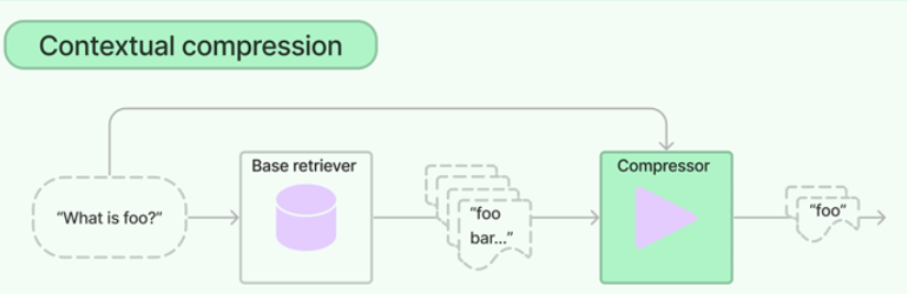

In [45]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import DocumentCompressorPipeline

**LLMChainExtractor:** iterate over the initially returned documents and extract from each only the content that is relevant to the query.

In [46]:
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor,
                                                       base_retriever=lotr)

compressed_docs = compression_retriever.get_relevant_documents("How is Microsoft Azure doing?")
print("No of documents retrieved after compression: " + str(len(compressed_docs)))
pretty_print_docs(compressed_docs)

No of documents retrieved after compression: 4
Document 1:

The Microsoft Cloud provides  the best integration across the technology stack while offering openness, improving time to value, reducing costs, and increasing agility. Being a global -scale cloud, Azure uniquely offers hybrid consistency, developer productivity, AI capabilities, and trusted security and compliance. We see more emerging use cases and needs for compute and security at the edge and are accelerating our innovation across th e spectrum of intelligent edge devices, from Internet of Things (“IoT”) s ensors to gateway devices and edge hardware to build, manage, and secure edge workloads.  
Our AI platform, Azure AI, is helping organizations transform, bringing intelligence and insights to the hands of their employees and customers to solve their most pressing challenges. Organizations large and small are deploying Azure AI solutions to achieve more at scale, more easily, with the proper enterprise -level and responsi

**LLMChainFilter:** slightly simpler but more robust compressor that uses an LLM chain to decide which of the initially retrieved documents to filter out and which ones to return, without manipulating the document contents.

In [47]:
from langchain.retrievers.document_compressors import LLMChainFilter

_filter = LLMChainFilter.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=_filter,
                                                       base_retriever=lotr)
compressed_docs = compression_retriever.get_relevant_documents("Compare the Revenue trends of Microsoft between the years 2022 and 2023?")
print("No of documents retrieved after compression: " + str(len(compressed_docs)))
pretty_print_docs(compressed_docs)

No of documents retrieved after compression: 6
Document 1:

respectively.  
Intelligent Cloud  
Revenue increased  $12.9  billion or 17%. 
• Server products and cloud services revenue increased $ 12.6 billion or 19% driven by Azure and other cloud 
services. Azure and other cloud services revenue grew 29% driven by  growth in our consumption -based 
services. Server products revenue decreased 1% . 
• Enterprise Services revenue increased $ 315 million or 4% driven by growth in Enterprise Support Services, 
offset in part by a decline in Industry Solutions (formerly Microsoft Consulting Services ).

{'page': 41, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf'}
----------------------------------------------------------------------------------------------------
Document 2:

respectively.  
Intelligent Cloud  
Revenue increased  $12.9  billion or 17%. 
• Server products and cloud services revenue increased $ 12.6 billion or 19% driven by Azure and other clo

**EmbeddingsFilter:** Making an extra LLM call over each retrieved document is expensive and slow. The EmbeddingsFilter provides a cheaper and faster option by embedding the documents and query and only returning those documents which have sufficiently similar embeddings to the query.

In [48]:
from langchain.retrievers.document_compressors import EmbeddingsFilter

embeddings_filter = EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.83) # change to 0.8 to see the reduction in the num of docs retrieved
compression_retriever = ContextualCompressionRetriever(base_compressor=embeddings_filter,
                                                       base_retriever=lotr)
compressed_docs = compression_retriever.get_relevant_documents("Compare the 2023 Revenue of Microsoft and Apple?")
print("No of documents retrieved after compression: " + str(len(compressed_docs)))
pretty_print_docs(compressed_docs)

No of documents retrieved after compression: 5
Document 1:

Products and Services Performance
The following table shows net sales by category for 2023, 2022 and 2021 (dollars in millions):
2023
Change
2022
Change
2021
Net sales by category:
iPhone 
$
200,583 
(2)
%
$
205,489 
7 
%
$
191,973 
Mac 
29,357 
(27)
%
40,177 
14 
%
35,190 
iPad 
28,300 
(3)
%
29,292 
(8)
%
31,862 
Wearables, Home and Accessories 
39,845 
(3)
%
41,241 
7 
%
38,367 
Services 
85,200 
9 
%
78,129 
14 
%
68,425 
Total net sales
$
383,285 
(3)
%
$
394,328 
8 
%
$
365,817 
(1)
Products net sales include amortization of the deferred value of unspeciﬁed software upgrade rights, which are bundled in the sales price of the respective
product.
(2)
Services net sales include amortization of the deferred value of services bundled in the sales price of certain products.
iPhone
iPhone net sales decreased 2% or $4.9 billion during 2023 compared to 2022 due to lower net sales of non-Pro iPhone models, partially oﬀset by highe

**EmbeddingsRedundantFilter:** Removes redundant documents from the initial returned documents

In [50]:
from langchain.document_transformers  import EmbeddingsRedundantFilter

_filter = EmbeddingsRedundantFilter(embeddings=embeddings,similarity_threshold=0.83)
pipeline = DocumentCompressorPipeline(transformers=[_filter])
compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline,
                                                       base_retriever=lotr)
query = "Compare the growth rate of Microsoft and Apple"
# print("No of documents retrieved after removing redundant documents: " + str(len(compressed_docs)))
pretty_print_result(query, llm, compression_retriever)

Answer: In fiscal year 2023, Microsoft experienced a cloud revenue growth of 22%, with various segments like Dynamics 365 growing by 24% and Azure by 29%. In contrast, Apple's stock performance showed significant growth over five years, increasing from `$`100 to `$`411, indicating a strong overall growth trajectory. While specific growth rates for Apple in the same fiscal year are not provided, its cumulative stock performance suggests robust growth compared to Microsoft’s specific revenue increases.

No of documents retrieved: 2


Document 1:

PART II  
Item 7 
 
36 ITEM  7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND 
RESULTS OF OPERATIONS  
The following Management’s Discussion and Analysis of Financial Condition and Results of Operations (“MD&A”) is 
intended to help the reader understand the results of operations and financial condition of Microsoft Corporation. MD&A 
is provided as a supplem ent to, and should be read in conjunction with, our consolidated financial statements and the 
accompanying Notes to Financial Statements (Part II, Item  8 of this Form 10 -K). This section generally discusses the 
results of our operations for the year ended June 30, 2023  compared to the year ended June 30, 2022 . For a discussion 
of the year ended June 30, 2022  compared to the year ended June 30, 2021 , please refer to Part II, Item 7, 
“Management’s Discussion and Analysis of Financial Condition and Results of Operations” in our Annual Report on 
Form 10 -K for the year ended June 30, 2022 . 
OVERVIEW  
Microsoft is a technology company whose mission is to empower every person and every organization on the planet 
to achieve more. We strive to create local opportunity, growth, and impact in every country around the world. We are 
creating the platforms and tools , powered by artificial intelligence (“AI”),  that deliver better, faster, and more effective 
solutions to support small and large business competitiveness , improve educational and health outcomes,  grow public -
sector efficiency,  and empower human ingen uity. 
We generate revenue by offering a wide range of cloud -based solutions, content, and other services to people and 
businesses; licensing and supporting an array of software products; delivering relevant online advertising to a global 
audience; and designing and selling devices. Our most significant expenses are related to compensating employees; 
supporting  and investing in our cloud -based services, including datacenter  operations ; designing, manufacturing, 
marketing, and selling our other products and service s; and income taxes.  
Highlights from fiscal year 2023  compared with fiscal year 2022  included:  
• Microsoft Cloud revenue increased 22% to `$` 111.6 billion.  
• Office Commercial products and cloud services revenue increased  10% driven by Office 365 Commercial 
growth of  13%. 
• Office Consumer products and cloud services revenue increased  2% and Microsoft 365 Consumer 
subscribers increased to 67.0 million.  
• LinkedIn revenue increased  10%. 
• Dynamics products and cloud services revenue increased  16% driven by Dynamics 365 growth of 24%. 
• Server products and cloud services revenue increased  19% driven by Azure and other cloud services 
growth of 29%. 
• Windows original equipment manufacturer licensing (“Windows OEM”) revenue decreased  25%. 
• Devices revenue decreased  24%. 
• Windows Commercial products and cloud services revenue increased  5%. 
• Xbox content and services revenue decreased  3%.  
• Search and news advertising revenue excluding traffic acquisition costs increased  11%. 
Industry Trends  
Our industry is dynamic and highly competitive, with frequent changes in both technologies and business models. Each 
industry shift is an opportunity to conceive new products, new technologies, or new ideas that can further transform 
the industry and our business. At Microsoft, we push the boundaries of what is possible through a broad range of 
research and development activities that seek to identify and address the changing demands of customers and users, 
industry trends, and competitive forces.

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 36}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

Company Stock Performance
The following graph shows a comparison of cumulative total shareholder return, calculated on a dividend-reinvested basis, for the Company, the S&P 500 Index, the
S&P Information Technology Index and the Dow Jones U.S. Technology Supersector Index for the ﬁve years ended September 24, 2022. The graph assumes `$`100
was invested in each of the Company’s common stock, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector
Index as of the market close on September 29, 2017. Past stock price performance is not necessarily indicative of future stock price performance.
*
`$`100 invested on September 29, 2017 in stock or index, including reinvestment of dividends. Data points are the last day of each ﬁscal year for the Company’s
common stock and September 30th for indexes.
Copyright
 2022 Standard & Poor’s, a division of S&P Global. All rights reserved.
Copyright
 2022 S&P Dow Jones Indices LLC, a division of S&P Global. All rights reserved.
September
2017
September
2018
September
2019
September
2020
September
2021
September 2022
Apple Inc.
`$`
100 
`$`
149 
`$`
146 
`$`
303 
`$`
400 
`$`
411 
S&P 500 Index
`$`
100 
`$`
118 
`$`
123 
`$`
142 
`$`
184 
`$`
156 
S&P Information Technology Index
`$`
100 
`$`
131 
`$`
143 
`$`
210 
`$`
271 
`$`
217 
Dow Jones U.S. Technology Supersector Index
`$`
100 
`$`
131 
`$`
139 
`$`
208 
`$`
283 
`$`
209 
Item 6.    [Reserved]
©
©
Apple Inc. | 2022 Form 10-K | 19

{'page': 22, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf'}

In [ ]:
# identify the doc that got removed due to reduncdancy

## Type4 - Multi Query Retriever

The MultiQueryRetriever automates the process of prompt tuning by using an LLM to generate multiple queries from different perspectives for a given user input query. For each query, it retrieves a set of relevant documents and takes the unique union across all queries to get a larger set of potentially relevant documents.

By generating multiple perspectives on the same question, the MultiQueryRetriever might be able to overcome some of the limitations of the distance-based retrieval and get a richer set of results.

In [51]:
from langchain.retrievers.multi_query import MultiQueryRetriever
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

multi_query_retriever = MultiQueryRetriever.from_llm(retriever=compression_retriever,
                                                     llm=llm)

In [52]:
query = "How Microsoft windows user base growing?"# same question write it in a bad way and see if it gets better with this retriever.
pretty_print_result(query, llm, multi_query_retriever)

INFO:langchain.retrievers.multi_query:Generated queries: ['What trends are contributing to the growth of the Microsoft Windows user base?  ', '', 'In what ways has the number of Microsoft Windows users increased over recent years?  ', '', 'What factors are driving the expansion of the Microsoft Windows user community?']


Answer: The user base of Microsoft Windows is growing through several key factors: increased OEM licensing as manufacturers pre-install Windows on devices, demand for Windows Commercial offerings from businesses, and the expansion of Windows IoT for embedded systems. Additionally, the mix of computing devices and market demand in both developed and growth markets contribute to this growth.

No of documents retrieved: 4


Document 1:

PART I  
Item 1 
 
13 Our Enterprise Services business competes with a wide range of companies that provide strategy and business 
planning, application development, and infrastructure services, including multinational consulting firms and small niche 
businesses focused on speci fic technologies.  
More Personal Computing  
Our More Personal Computing segment consists of products and services that put customers at the center of the 
experience with our technology. This segment primarily comprises:  
• Windows, including Windows OEM  licensing  (“Windows OEM”)  and other non -volume licensing of the 
Windows operating system; Windows Commercial, comprising volume licensing of the Windows operating 
system, Windows cloud services, and other Windows commercial offerings; patent licensing; and Windows  
IoT. 
• Devices, including Surface, HoloLens, and PC accessories.  
• Gaming, including Xbox hardware and Xbox content and services, comprising first - and third -party content 
(including games and in -game content), Xbox Game Pass and other subscriptions, Xbox Cloud Gaming, 
advertising, third-party disc royalties, and other cloud services.  
• Search and news advertising, comprising Bing (including Bing Chat), Microsoft News, Microsoft Edge, and 
third-party affiliates.  
Windows  
The Windows operating system is designed to deliver a more personal computing experience for users by enabling 
consistency of experience, applications, and information across their devices. Windows OEM revenue is impacted 
significantly by the number of Win dows operating system licenses purchased by OEMs, which they pre -install on the 
devices they sell. In addition to computing device market volume, Windows OEM revenue is impacted by:  
• The mix of computing devices based on form factor and screen size.  
• Differences in device market demand between developed markets and growth markets.  
• Attachment of Windows to devices shipped.  
• Customer mix between consumer, small and medium businesses, and large enterprises.  
• Changes in inventory levels in the OEM channel.  
• Pricing changes and promotions, pricing variation that occurs when the mix of devices manufactured shifts 
from local and regional system builders to large multinational OEMs, and different pricing of Windows 
versions licensed.  
• Constraints in the supply chain of device components.  
• Piracy.  
Windows Commercial revenue, which includes volume licensing of the Windows operating system and Windows cloud 
services such as Microsoft Defender for Endpoint, is affected mainly by the demand from commercial customers for 
volume licensing and Software Ass urance (“SA”), as well as advanced security offerings. Windows Commercial 
revenue often reflects the number of information workers in a licensed enterprise and is relatively independent of the 
number of PCs sold in a given year.  
Patent licensing includes our programs to license patents we own for use across a broad array of technology areas, 
including mobile devices and cloud offerings.  
Windows IoT extends the power of Windows and the cloud to intelligent systems by delivering specialized operating 
systems, tools, and services for use in embedded devices.  
Devices  
We design and sell devices, including Surface , HoloLens,  and PC accessories. Our devices are designed to enable 
people and organizations to connect to the people and content that matter most using Windows and integrated 
Microsoft products and services. Surface is designed to help organizations, students, and co nsumers be more

{'page': 13, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

Exhibit 32.2  
CERTIFICATION PURSUANT TO  
SECTION 906 OF THE SARBANES -OXLEY ACT OF 2002  
(18 U.S.C. SECTION 1350)  
In connection with the Annual Report of Microsoft Corporation, a Washington corporation (the “Company”), on Form  10-
K for the year ended June 30, 2023 , as filed with the Securities and Exchange Commission (the “Report”), Amy E. 
Hood, Chief Financial Officer of the Company, does hereby certify, pursuant to § 906 of the Sarbanes -Oxley Act of 
2002 (18 U.S.C. § 1350), that to her knowledge:  
(1) The Report fully complies with the requirements of section 13(a) or 15(d) of the Securities Exchange Act of 1934; 
and  
(2) The information contained in the Report fairly presents, in all material respects, the financial condition and results 
of operations of the Company.  
  
 
 
/s/ A MY E. H OOD  
Amy E. Hood  
Executive Vice President and  
Chief Financial Officer  
July 27 , 2023   
[A signed original of this written statement required by Section  906 has been provided to Microsoft Corporation and will 
be retained by Microsoft Corporation and furnished to the Securities and Exchange Commission or its staff upon 
request.]

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 115}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

The Company continues to monitor the situation and take appropriate actions in accordance with the recommendations and requirements of relevant authorities. The
extent to which the COVID-19 pandemic may impact the Company’s operational and ﬁnancial performance remains uncertain and will depend on many factors
outside the Company’s control, including the timing, extent, trajectory and duration of the pandemic, the emergence of new variants, the development, availability,
distribution and eﬀectiveness of vaccines and treatments, the imposition of protective public safety measures, and the impact of the pandemic on the global economy
and demand for consumer products and services. Additional future impacts on the Company may include material adverse eﬀects on demand for the Company’s
products and services, the Company’s supply chain and sales and distribution channels, the Company’s ability to execute its strategic plans, and the Company’s
profitability and cost structure.
To the extent the COVID-19 pandemic adversely aﬀects the Company’s business, results of operations, ﬁnancial condition and stock price, it may also have the eﬀect
of heightening many of the other risks described in this Part I, Item 1A of this Form 10-K.
The Company’s business can be impacted by political events, trade and other international disputes, war, terrorism, natural disasters, public health
issues, industrial accidents and other business interruptions.
Political events, trade and other international disputes, war, terrorism, natural disasters, public health issues, industrial accidents and other business interruptions can
harm or disrupt international commerce and the global economy, and could have a material adverse eﬀect on the Company and its customers, suppliers, contract
manufacturers, logistics providers, distributors, cellular network carriers and other channel partners.
The Company has a large, global business with sales outside the U.S. representing a majority of the Company’s total net sales, and the Company believes that it
generally beneﬁts from growth in international trade. Substantially all of the Company’s manufacturing is performed in whole or in part by outsourcing partners located
primarily in Asia, including China mainland, India, Japan, South Korea, Taiwan and Vietnam. Trade policies and disputes and other international conﬂicts can result in
tariﬀs, sanctions and other measures that restrict international trade, and can materially adversely aﬀect the Company’s business, particularly if these measures occur
in regions where the Company derives a signiﬁcant portion of its revenues and/or has signiﬁcant supply chain operations. For example, tensions between the U.S.
and China have led to a series of tariﬀs being imposed by the U.S. on imports from China mainland, as well as other business restrictions. Tariﬀs increase the cost of
the Company’s products and the components and raw materials that go into making them. These increased costs can adversely impact the gross margin that the
Company earns on its products. Tariﬀs can also make the Company’s products more expensive for customers, which could make the Company’s products less
competitive and reduce consumer demand. Countries may also adopt other measures, such as controls on imports or exports of goods, technology or data, that could
adversely impact the Company’s operations and supply chain and limit the Company’s ability to oﬀer its products and services as designed. These measures can
require the Company to take various actions, including changing suppliers, restructuring business relationships, and ceasing to oﬀer third-party applications on its
platforms. Changing the Company’s operations in accordance with new or changed trade restrictions can be expensive, time-consuming and disruptive to the
Company’s operations. Such restrictions can be announced with little or no advance notice and the Company may not be able to eﬀectively mitigate all adverse
impacts from such measures. If disputes and conﬂicts further escalate in the future, actions by governments in response could be signiﬁcantly more severe and
restrictive and could materially adversely aﬀect the Company’s business. Political uncertainty surrounding trade and other international disputes could also have a
negative effect on consumer confidence and spending, which could adversely affect the Company’s business.
Many of the Company’s operations and facilities, as well as critical business operations of the Company’s suppliers and contract manufacturers, are in locations that

{'page': 9, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

based on factors such as the market position of the Company and its products, the anticipated revenue that may be generated, expected future growth of product
sales, and the costs of developing such applications and services.
The Company’s minority market share in the global smartphone, personal computer and tablet markets can make developers less inclined to develop or upgrade
software for the Company’s products and more inclined to devote their resources to developing and upgrading software for competitors’ products with larger market
share. When developers focus their efforts on these competing platforms, the availability and quality of applications for the Company’s devices can suffer.
The Company relies on the continued availability and development of compelling and innovative software applications for its products. The Company’s products and
operating systems are subject to rapid technological change, and when third-party developers are unable to or choose not to keep up with this pace of change, their
applications can fail to take advantage of these changes to deliver improved customer experiences, can operate incorrectly, and can result in dissatisﬁed customers
and lower customer demand for the Company’s products.

{'page': 12, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2023.pdf'}

In [53]:
query = "Where is Apple's headquarters?"
pretty_print_result(query, llm, multi_query_retriever)

INFO:langchain.retrievers.multi_query:Generated queries: ["What is the location of Apple's main office?  ", "Can you tell me the address of Apple's corporate headquarters?  ", "In which city is Apple's headquarters situated?"]


Answer: Apple's headquarters is located at One Apple Park Way, Cupertino, California, 95014.

No of documents retrieved: 10


Document 1:

PART I  
Item 1 
 
16 worldwide. While we employ much of our internally -developed intellectual property in our products and services, we 
also engage in outbound licensing of specific patented technologies that are incorporated into licensees’ products. 
From time to time, we ent er into broader cross -license agreements with other technology companies covering entire 
groups of patents. We may also purchase or license technology that we incorporate into our products and services. At 
times, we make select intellectual property broadl y available at no or low cost to achieve a strategic objective, such as 
promoting industry standards, advancing interoperability, supporting societal and/or environmental efforts, or attracting 
and enabling our external development community. Our increasin g engagement with open source software will also 
cause us to license our intellectual property rights broadly in certain situations.  
While it may be necessary in the future to seek or renew licenses relating to various aspects of our products  and 
services, we believe, based upon past experience and industry practice, such licenses generally can be obtained on 
commercially reasonable terms. We believe our continuing research and product development are not materially 
dependent on any single license  or other agreement with a third party relating to the development of our products.  
Investing in the Future  
Our success is based on our ability to create new and compelling products, services, and experiences for our users, 
to initiate and embrace disruptive technology trends, to enter new geographic and product markets, and to drive broad 
adoption of our produc ts and services. We invest in a range of emerging technology trends and breakthroughs that we 
believe offer significant opportunities to deliver value to our customers and growth for the company. Based on our 
assessment of key technology trends, we maintai n our long -term commitment to research and development across a 
wide spectrum of technologies, tools, and platforms spanning digital work and life experiences, cloud computing, AI, 
devices, and operating systems.   
While our main product research and development facilities are located in Redmond, Washington, we also operate 
research and development facilities in other parts of the U.S. and around the world. This global approach helps us 
remain competitive in local ma rkets and enables us to continue to attract top talent from across the world.  
We plan to continue to make significant investments in a broad range of product research and development activities, 
and as appropriate we will coordinate our research and development across operating segments and leverage the 
results across the company.   
In addition to our main research and development operations, we also operate Microsoft Research. Microsoft Research 
is one of the world’s largest corporate research organizations , often  work ing in close collaboration with top universities 
around the world , and is focused on advancing the state -of-the-art in computer science and a broad range of other 
disciplines . Our investment in fundamental research  provides  us a unique perspective on future trends and contributes  
to our innovation.  
DISTRIBUTION, SALES, AND MARKETING  
We market and distribute our products and services through the following channels: OEMs, direct, and distributors and 
resellers. Our sales  organization  performs a variety of functions, including working directly with commercial enterprises 
and public -sector organizations worldwide to identify and meet their technology and digital transformation 
requirements; managing OEM relationships; and supporting sys tem integrators, independent software vendors, and 
other partners who engage directly with our customers to perform sales, consulting, and fulfillment functions for our 
products and services.  
OEMs

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 16}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

Total    `$` 211,915     `$` 198,270      `$` 168,088    
                       
Our Microsoft Cloud  revenue, which includes Azure and other cloud services, Office 365 Commercial, the commercial 
portion of LinkedIn, Dynamics 365, and other commercial cloud properties, was `$` 111.6 billion, `$` 91.4 billion , and `$` 69.1 
billion in fiscal years 2023 , 2022 , and 2021 , respectively. These amounts are primarily included in Server products and 
cloud services, Office products and cloud services, LinkedIn , and Dynamics  in the table above.  
Assets are not allocated to segments for internal reporting presentations. A portion of amortization and depreciation is 
included with various other costs in an overhead allocation to each segment. It is impracticable for us to separately 
identify the amount of amortization and depreciation by segment that is inclu ded in the measure of segment profit or 
loss. 
Long -lived assets, excluding financial instruments and tax assets, classified by the location of the controlling statutory 
company and with countries over 10% of the total shown separately, were as follows:  
 
(In millions)        
   
     
June  30,    2023     2022     2021   
    
United States    `$` 114,380      `$` 106,430      `$` 76,153    
Ireland      16,359        15,505        13,303    
Other countries      56,50 0       44,433        38,858                                  
Total    `$` 187,2 39     `$` 166,368      `$`  128,314

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 91}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

Services
Advertising
The Company’s advertising services include third-party licensing arrangements and the Company’s own advertising platforms.
AppleCare
The Company oﬀers a portfolio of fee-based service and support products under the AppleCare
 brand. The oﬀerings provide priority access to Apple technical
support, access to the global Apple authorized service network for repair and replacement services, and in many cases additional coverage for instances of accidental
damage or theft and loss, depending on the country and type of product.
Cloud Services
The Company’s cloud services store and keep customers’ content up-to-date and available across multiple Apple devices and Windows personal computers.
Digital Content
The Company operates various platforms, including the App Store
,
 that allow customers to discover and download applications and digital content, such as books,
music, video, games and podcasts.
The Company also oﬀers digital content through subscription-based services, including Apple Arcade
, a game subscription service; Apple Fitness+
, a personalized
ﬁtness service; Apple Music
, which oﬀers users a curated listening experience with on-demand radio stations; Apple News+
, a subscription news and magazine
service; and Apple TV+
, which offers exclusive original content and live sports.
Payment Services
The Company offers payment services, including Apple Card
, a co-branded credit card, and Apple Pay
, a cashless payment service.
Segments
The Company manages its business primarily on a geographic basis. The Company’s reportable segments consist of the Americas, Europe, Greater China, Japan
and Rest of Asia Paciﬁc. Americas includes both North and South America. Europe includes European countries, as well as India, the Middle East and Africa. Greater
China includes China mainland, Hong Kong and Taiwan. Rest of Asia Paciﬁc includes Australia and those Asian countries not included in the Company’s other
reportable segments. Although the reportable segments provide similar hardware and software products and similar services, each one is managed separately to
better align with the location of the Company’s customers and distribution partners and the unique market dynamics of each geographic region.
Markets and Distribution
The Company’s customers are primarily in the consumer, small and mid-sized business, education, enterprise and government markets. The Company sells its
products and resells third-party products in most of its major markets directly to customers through its retail and online stores and its direct sales force. The Company
also employs a variety of indirect distribution channels, such as third-party cellular network carriers, wholesalers, retailers and resellers. During 2023, the Company’s
net sales through its direct and indirect distribution channels accounted for 37% and 63%, respectively, of total net sales.
Competition
The markets for the Company’s products and services are highly competitive, and are characterized by aggressive price competition and resulting downward pressure
on gross margins, frequent introduction of new products and services, short product life cycles, evolving industry standards, continual improvement in product price
and performance characteristics, rapid adoption of technological advancements by competitors, and price sensitivity on the part of consumers and businesses. Many
of the Company’s competitors seek to compete primarily through aggressive pricing and very low cost structures, and by imitating the Company’s products and
infringing on its intellectual property.
®
®
®
SM
®
®
®
®
®

{'page': 5, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

PART I  
Item 1 
 
20 AVAILABLE INFORMATION  
Our Internet address is www.microsoft.com. At our Investor Relations website, www.microsoft.com/investor, we make 
available free of charge a variety of information for investors. Our goal is to maintain the Investor Relations website as 
a portal through which investors can easily find or navigate to pertinent information about us, including:  
• Our annual report on Form 10 -K, quarterly reports on Form 10 -Q, current reports on Form 8 -K, and any 
amendments to those reports, as soon as reasonably practicable after we electronically file that material 
with or furnish it to the Securities and Exchange  Commission (“SEC”) at www.sec.gov . 
• Information on our business strategies, financial results, and metrics for investors.  
• Announcements of investor conferences, speeches, and events at which our executives talk about our 
product, service, and competitive strategies. Archives of these events are also available.  
• Press releases on quarterly earnings, product and service announcements, legal developments, and 
international news.  
• Corporate governance information including our articles of incorporation, bylaws, governance guidelines, 
committee charters, codes of conduct and ethics, global corporate social responsibility initiatives, and other 
governance -related policies.  
• Other news and announcements that we may post from time to time that investors might find useful or 
interesting.  
• Opportunities to sign up for email alerts to have information pushed in real time.  
We publish a variety of reports and resources related to our Corporate Social Responsibility programs and progress 
on our Reports Hub website, www.microsoft.com/corporate -responsibility/reports -hub, including reports on 
sustainability, responsible sourcing, accessibility, digital trust, and public policy engagement.  
The information found on  these websites is not part of, or incorporated by reference into, this or any other report we 
file with, or furnish to, the SEC. In addition to these channels, we use social media to communicate to the public. It is 
possible that the information we post on  social media could be deemed to be material to investors. We encourage 
investors, the media, and others interested in Microsoft to review the information we post on the social media channels 
listed on our Investor Relations websit e.

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 20}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 5:

2025, representing half of the country’s workforce shortage. To that end, we are making curriculum available free of 
charge to all of the nation’s higher education institutions, providing training for new and existing faculty, and providing 
scholarships and supplemental resources to 25,000 students. We have expanded the cyber skills initiative to 27 
additional countries that show elevated cybert hreat risks coupled with significant gaps in their cybersecurity workforces, 
partnering with nonprofits and other educational institutions to train the next generation of cybersecurity workers.  
Generative AI is creating unparalleled opportunities to empower workers globally, but only if everyone has the skills to 
use it. To address this, in June 2023 we launched a new AI Skills Initiative to help everyone learn how to harness the 
power of AI. This includes a new LinkedIn learning pathway offering new coursework on learning the foundations of 
generative AI. We also launched a new global grant challenge to uncover new ways of training workers on generative 
AI and are providing greater access to digi tal learning events and resources for everyone to improve their AI fluency.

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 7}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 6:

and processes.
The Company has implemented systems and processes intended to secure its information technology systems and prevent unauthorized access to or loss of
sensitive data, and mitigate the impact of unauthorized access, including through the use of encryption and authentication technologies. As with all companies, these
security measures may not be sufficient for all eventualities and may be vulnerable to hacking, ransomware attacks, employee error, malfeasance, system error, faulty
password management or other irregularities. For example, third parties can fraudulently induce the Company’s or its vendors’ employees or customers into
disclosing usernames, passwords or other sensitive information, which can, in turn, be used for unauthorized access to the Company’s or its vendors’ systems and
services. To help protect customers and the Company, the Company deploys and makes available technologies like multifactor authentication, monitors its services
and systems for unusual activity and may freeze accounts under suspicious circumstances, which, among other things, can result in the delay or loss of customer
orders or impede customer access to the Company’s products and services.
While the Company maintains insurance coverage that is intended to address certain aspects of data security risks, such insurance coverage may be insuﬃcient to
cover all losses or all types of claims that may arise.

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2023.pdf', 'page': 14}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 7:

UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 
10-K
(Mark One)
☒
 
ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the fiscal year ended 
September 30
, 2023
or
☐
 
TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the transition period from 
            
 to 
            
.
Commission File Number: 
001-36743
Apple Inc.
(Exact name of Registrant as specified in its charter)
California
94-2404110
(State or other jurisdiction
of incorporation or organization)
(I.R.S. Employer Identification No.)
One Apple Park Way
Cupertino
, 
California
95014
(Address of principal executive offices)
(Zip Code)
(
408
) 
996-1010
(Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each class
Trading symbol(s)
Name of each exchange on which registered
Common Stock, `$`0.00001 par value per share
AAPL
The Nasdaq Stock Market LLC
1.375% Notes due 2024
—
The Nasdaq Stock Market LLC
0.000% Notes due 2025
—
The Nasdaq Stock Market LLC
0.875% Notes due 2025
—
The Nasdaq Stock Market LLC
1.625% Notes due 2026
—
The Nasdaq Stock Market LLC
2.000% Notes due 2027
—
The Nasdaq Stock Market LLC
1.375% Notes due 2029
—
The Nasdaq Stock Market LLC
3.050% Notes due 2029
—
The Nasdaq Stock Market LLC
0.500% Notes due 2031
—
The Nasdaq Stock Market LLC
3.600% Notes due 2042
—
The Nasdaq Stock Market LLC
Securities registered pursuant to Section 12(g) of the Act: 
None
Indicate by check mark if the Registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act.
Yes
  
☒
     No  
☐
Indicate by check mark if the Registrant is not required to file reports pursuant to Section 13 or Section 15(d) of the Act.
Yes  
☐
     
No
  
☒
Indicate by check mark whether the Registrant (1) has ﬁled all reports required to be ﬁled by Section 13 or 15(d) of the Securities Exchange Act of 1934 during the preceding 12
months (or for such shorter period that the Registrant was required to file such reports), and (2) has been subject to such filing requirements for the past 90 days.
Yes
  
☒
     No  
☐
Indicate by check mark whether the Registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T (§232.405 of
this chapter) during the preceding 12 months (or for such shorter period that the Registrant was required to submit such files).
Yes
  
☒
     No  
☐
Indicate by check mark whether the Registrant is a large accelerated ﬁler, an accelerated ﬁler, a non-accelerated ﬁler, a smaller reporting company, or an emerging growth company.
See the definitions of “large accelerated filer,” “accelerated filer,” “smaller reporting company,” and “emerging growth company” in Rule 12b-2 of the Exchange Act.
Large accelerated filer
☒
Accelerated filer
☐
Non-accelerated filer
☐
Smaller reporting company
☐
Emerging growth company
☐

{'page': 1, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 8:

PART I 
Item 1B, 2, 3, 4  
 
34 ITEM  1B. UNRESOLVED STAFF COMMENTS  
We have received no written comments regarding our periodic or current reports from the staff of the Securities and 
Exchange Commission that were issued 180 days or more preceding the end of our fiscal year 2023  that remain 
unresolved.  
ITEM  2. PROPERTIES  
Our corporate headquarters are located in Redmond, Washington. We have approximately 16 million square feet of 
space located in King County, Washington that is used for engineering, sales, marketing, and operations, among other 
general and administrative purposes. These facilities include approximately 11 million square feet of owned space 
situated on approximately 5 30 acres of land we own at our corporate headquarters, and approximately 5 million square 
feet of space we lease.  
We own and lease  other facilities domestically and internationally , primarily  for office s, datacenter s, and research and 
development . The largest owned international properties include space in the following locations: China, India, Ireland, 
and the Netherlands. The largest leased international properties include space in the following locations: Australia, 
Canada, China, France, Germany, India, Ireland, Israel, Japan,  the Netherlands, and the United Kingdom.  Refer to  
Research and Development (Part I, Item  1 of this Form 10 -K) for further discussion of our research and development 
facilities . 
In fiscal year 2023, we made  decisions to consolidate our office leases to create higher density across our workspaces , 
and we may make similar decisions in future periods as we continue to evaluate our real estate needs.  
The table below shows a summary of the square footage of our properties  owned and leased domestically and 
internationally as of June 30, 2023 : 
 
(Square feet in millions)    
   
     
Location    Owned      Leased      Total   
    
U.S.     27      20      47   
International      9       22       31   
             
          
Total     36      42      78   
                       
ITEM  3. LEGAL PROCEEDINGS  
Refer to Note 15 – Contingencies of the Notes to Financial Statements (Part II, Item  8 of this Form 10 -K) for information 
regarding legal proceedings in which we are involved.  
ITEM  4. MINE SAFETY DISCLOSURES  
Not applicable.

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 34}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 9:

The Company is also subject to the examination of its tax returns and other tax matters by the U.S. Internal Revenue Service and other tax authorities and
governmental bodies. The Company regularly assesses the likelihood of an adverse outcome resulting from these examinations to determine the adequacy of its
provision for taxes. There can be no assurance as to the outcome of these examinations. If the Company’s eﬀective tax rates were to increase, particularly in the U.S.
or Ireland, or if the ultimate determination of the Company’s taxes owed is for an amount in excess of amounts previously accrued, the Company’s business, results of
operations and financial condition could be materially adversely affected.
General Risks
The price of the Company’s stock is subject to volatility.
The Company’s stock has experienced substantial price volatility in the past and may continue to do so in the future. Additionally, the Company, the technology
industry and the stock market as a whole have, from time to time, experienced extreme stock price and volume ﬂuctuations that have aﬀected stock prices in ways
that may have been unrelated to these companies’ operating performance. Price volatility may cause the average price at which the Company repurchases its stock in
a given period to exceed the stock’s price at a given point in time. The Company believes the price of its stock should reﬂect expectations of future growth and
proﬁtability. The Company also believes the price of its stock should reﬂect expectations that its cash dividend will continue at current levels or grow, and that its
current share repurchase program will be fully consummated. Future dividends are subject to declaration by the Company’s Board of Directors, and the Company’s
share repurchase program does not obligate it to acquire any speciﬁc number of shares. If the Company fails to meet expectations related to future growth,
proﬁtability, dividends, share repurchases or other market expectations, the price of the Company’s stock may decline signiﬁcantly, which could have a material
adverse impact on investor confidence and employee retention.
Item 1B.    Unresolved Staff Comments
None.
Item 2.    Properties
The Company’s headquarters are located in Cupertino, California. As of September 24, 2022, the Company owned or leased facilities and land for corporate
functions, R&D, data centers, retail and other purposes at locations throughout the U.S. and in various places outside the U.S. The Company believes its existing
facilities and equipment, which are used by all reportable segments, are in good operating condition and are suitable for the conduct of its business.
Item 3.    Legal Proceedings
Epic Games
Epic Games, Inc. (“Epic”) ﬁled a lawsuit in the U.S. District Court for the Northern District of California (the “Northern California District Court”) against the Company
alleging violations of federal and state antitrust laws and California’s unfair competition law based upon the Company’s operation of its App Store. The Company ﬁled
a counterclaim for breach of contract. On September 10, 2021, the Northern California District Court ruled in favor of the Company with respect to nine out of the ten
counts included in Epic’s claim, and in favor of the Company with respect to the Company’s claims for breach of contract. The Northern California District Court found
that certain provisions of the Company’s App Store Review Guidelines violate California’s unfair competition law and issued an injunction. Epic appealed the decision.
The Company filed a cross-appeal and has been granted a stay pending the appeal.
Other Legal Proceedings
The Company is subject to other legal proceedings and claims that have not been fully resolved and that have arisen in the ordinary course of business. The
Company settled certain matters during the fourth quarter of 2022 that did not individually or in the aggregate have a material impact on the Company’s ﬁnancial
condition or operating results. The outcome of litigation is inherently uncertain. If one or more legal matters were resolved against the Company in a reporting period

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf', 'page': 20}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 10:

UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 
10-K
(Mark One)
☒
 
ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the fiscal year ended 
September 24
, 2022
or
☐
 
TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the transition period from 
            
 to 
            
.
Commission File Number: 
001-36743
Apple Inc.
(Exact name of Registrant as specified in its charter)
California
94-2404110
(State or other jurisdiction
of incorporation or organization)
(I.R.S. Employer Identification No.)
One Apple Park Way
Cupertino
, 
California
95014
(Address of principal executive offices)
(Zip Code)
(
408
) 
996-1010
(Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each class
Trading symbol(s)
Name of each exchange on which registered
Common Stock, `$`0.00001 par value per share
AAPL
The Nasdaq Stock Market LLC
1.000% Notes due 2022
—
The Nasdaq Stock Market LLC
1.375% Notes due 2024
—
The Nasdaq Stock Market LLC
0.000% Notes due 2025
—
The Nasdaq Stock Market LLC
0.875% Notes due 2025
—
The Nasdaq Stock Market LLC
1.625% Notes due 2026
—
The Nasdaq Stock Market LLC
2.000% Notes due 2027
—
The Nasdaq Stock Market LLC
1.375% Notes due 2029
—
The Nasdaq Stock Market LLC
3.050% Notes due 2029
—
The Nasdaq Stock Market LLC
0.500% Notes due 2031
—
The Nasdaq Stock Market LLC
3.600% Notes due 2042
—
The Nasdaq Stock Market LLC
Securities registered pursuant to Section 12(g) of the Act: 
None
Indicate by check mark if the Registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act.
Yes
  
☒
     No  
☐
Indicate by check mark if the Registrant is not required to file reports pursuant to Section 13 or Section 15(d) of the Act.
Yes  
☐
     
No
  
☒
Indicate by check mark whether the Registrant (1) has ﬁled all reports required to be ﬁled by Section 13 or 15(d) of the Securities Exchange Act of 1934 during the preceding 12
months (or for such shorter period that the Registrant was required to file such reports), and (2) has been subject to such filing requirements for the past 90 days.
Yes
  
☒
     No  
☐
Indicate by check mark whether the Registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T (§232.405 of
this chapter) during the preceding 12 months (or for such shorter period that the Registrant was required to submit such files).
Yes
  
☒
     No  
☐
Indicate by check mark whether the Registrant is a large accelerated ﬁler, an accelerated ﬁler, a non-accelerated ﬁler, a smaller reporting company, or an emerging growth company.
See the definitions of “large accelerated filer,” “accelerated filer,” “smaller reporting company,” and “emerging growth company” in Rule 12b-2 of the Exchange Act.
Large accelerated filer
☒
Accelerated filer
☐
Non-accelerated filer
☐
Smaller reporting company
☐
Emerging growth company
☐

{'page': 1, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf'}

In [54]:
query = "When is Apple planning to achieve Carbon neutral?"
pretty_print_result(query, llm, multi_query_retriever)

INFO:langchain.retrievers.multi_query:Generated queries: ["What is Apple's timeline for reaching carbon neutrality?  ", 'What are the goals and deadlines set by Apple for achieving carbon neutrality?  ', "Can you provide information on Apple's plans and schedule for becoming carbon neutral?"]


Answer: Apple is planning to achieve carbon neutrality by 2030.

No of documents retrieved: 8


Document 1:

motion to e xclude the plaintiffs’ general causation experts. The defendants filed an interlocutory appeal to the District 
of Columbia Court of Appeals challenging the standard for evaluating expert scientific evidence. In October 2016, the 
Court of Appeals issued its  decision adopting the standard advocated by the defendants and remanding the cases to 
the trial court for further proceedings under that standard. The plaintiffs have filed supplemental expert evidence, 
portions of which were stricken by the court. A hear ing on general causation took place in September of 2022.  In April 
of 2023, the court granted defendants’ motion to strike the testimony of plaintiffs’ experts that cell phones cause brain 
cancer and entered an order excluding all of plaintiffs’ experts fr om testifying.  
Irish Data Protection Commission Matter  
In 2018, the Irish Data Protection Commission ( “IDPC ”) began investigating a complaint against LinkedIn as to whether 
LinkedIn’s targeted advertising practices violated the recently implemented European Union General Data Protection 
Regulation ( “GDPR ”). Microsoft cooperated throughout the period of inquiry. In April 2023, the IDPC provided LinkedIn 
with a non -public preliminary draft decision alleging GDPR violations and proposing a fine. Microsoft intends to 
challenge the preliminary draft decision. There is no set timeline for the IDPC to issue a final decision.

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 84}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

PART I  
Item 1 
 
3 Note About Forward -Looking Statements  
This report includes estimates, projections, statements relating to our business plans, objectives, and expected 
operating results that are “forward -looking statements” within the meaning of the Private Securities Litigation Reform 
Act of 1995, Section  27A of the Securities Act of 1933, and Section  21E of the Securities Exchange Act of 1934. 
Forward -looking statements may appear throughout this report, including the following sections: “Business” (Part I, 
Item 1 of this Form 10 -K), “Risk Factors” (Part I, I tem 1A of this Form 10 -K), and “Management’s Discussion and 
Analysis of Financial Condition and Results of Operations” (Part II, Item  7 of this Form 10 -K). These forward -looking 
statements generally are identified by the words “believe,” “project,” “expect,” “anticipate,” “estimate,” “intend,” 
“strategy,” “future,” “opportunity,” “plan,” “may,” “should,” “will,” “would,” “will be,” “will  continue,” “will likely result,” and 
similar expressions. Forward -looking statements are based on current expectations an d assumptions that are subject 
to risks and uncertainties that may cause actual results to differ materially. We describe risks and uncertainties that 
could cause actual results and events to differ materially in “Risk Factors,” “Management’s Discussion an d Analysis of 
Financial Condition and Results of Operations,” and “Quantitative and Qualitative Disclosures about Market Risk” (Part 
II, Item  7A of this Form 10 -K). Readers are cautioned not to place undue reliance on forward -looking statements, which 
spea k only as of the date they are made. We undertake no obligation to update or revise publicly any forward -looking 
statements, whether because of new information, future events, or otherwise.  
PART I  
ITEM  1. BUSINESS  
GENERAL  
Embracing Our Future  
Microsoft is a technology company whose mission is to empower every person and every organization on the planet 
to achieve more. We strive to create local opportunity, growth, and impact in every country around the world. We are 
creating the platforms and tools , powered by artificial intelligence (“A I”), that deliver better, faster, and more effective 
solutions to support small and large business competitiveness , improve educational and health outcomes, grow public -
sector efficiency, and empower human ingen uity. From infrastructure and data, to business applications and 
collaboration, we provide unique , differentiated value to customers.  
In a world of increasing economic complexity, AI has the power to revolutionize many types of work. Microsoft is now 
innovating and expanding our portfolio with AI capabilities to help people and organizations overcome today’s 
challenges and emerge stronger. Customers are looking to unlock value from their digital spend and innovate for this 
next generation of AI, while simplifying security and management.  Those leveraging the Microsoft Cloud are best 
positioned to take advantage of technological advancemen ts and drive innovation.  Our investment in AI spans the 
entire company, from Microsoft Teams and Outlook, to Bing and Xbox, and we are infusing generative AI capability 
into our consumer and commercial offerings to deliver copilot capability for all services across the Microsoft Cloud.  
We’re committed to making the promise of AI real – and doing it responsibly. Our work is guided by a core set of 
principles: fairness, reliability and safety, privacy and security, inclusiveness, transparency, and accountability.  
What We Offer  
Founded in 1975, we develop and support software, services, devices, and solutions that deliver new value for 
customers and help people and businesses realize their full potential.  
We offer an array of services, including cloud -based solutions that provide customers with software, services, 
platforms, and content, and we provide solution support and consulting services. We also deliver relevant online

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 3}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

Apple Inc.
Notes to Consolidated Financial Statements
Note 1 – 
Summary of Significant Accounting Policies
Basis of Presentation and Preparation
The consolidated ﬁnancial statements include the accounts of Apple Inc. and its wholly owned subsidiaries. The preparation of these consolidated ﬁnancial
statements and accompanying notes in conformity with GAAP requires the use of management estimates. Certain prior period amounts in the consolidated ﬁnancial
statements and accompanying notes have been reclassified to conform to the current period’s presentation.
The Company’s ﬁscal year is the 52- or 53-week period that ends on the last Saturday of September. An additional week is included in the ﬁrst ﬁscal quarter every
ﬁve or six years to realign the Company’s ﬁscal quarters with calendar quarters, which occurred in the ﬁrst ﬁscal quarter of 2023. The Company’s ﬁscal year 2023
spanned 53 weeks, whereas ﬁscal years 2022 and 2021 spanned 52 weeks each. Unless otherwise stated, references to particular years, quarters, months and
periods refer to the Company’s fiscal years ended in September and the associated quarters, months and periods of those fiscal years.
Revenue
The Company records revenue net of taxes collected from customers that are remitted to governmental authorities.
Share-Based Compensation
The Company recognizes share-based compensation expense on a straight-line basis for its estimate of equity awards that will ultimately vest.
Cash Equivalents
All highly liquid investments with maturities of three months or less at the date of purchase are treated as cash equivalents.
Marketable Securities
The cost of securities sold is determined using the specific identification method.
Inventories
Inventories are measured using the first-in, first-out method.
Property, Plant and Equipment
Depreciation on property, plant and equipment is recognized on a straight-line basis.
Derivative Instruments
The Company presents derivative assets and liabilities at their gross fair values in the Consolidated Balance Sheets.
Income Taxes
The Company records certain deferred tax assets and liabilities in connection with the minimum tax on certain foreign earnings created by the Act.
Leases
The Company combines and accounts for lease and nonlease components as a single lease component for leases of corporate, data center and retail facilities.
Apple Inc. | 2023 Form 10-K | 33

{'page': 36, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

Compliance with these laws and regulations is onerous and expensive. New and changing laws and regulations can adversely aﬀect the Company’s business by
increasing the Company’s costs, limiting the Company’s ability to oﬀer a product, service or feature to customers, impacting customer demand for the Company’s
products and services, and requiring changes to the Company’s supply chain and its business. New and changing laws and regulations can also create uncertainty
about how such laws and regulations will be interpreted and applied. These risks and costs may increase as the Company’s products and services are introduced into
specialized applications, including health and ﬁnancial services. The Company has implemented policies and procedures designed to ensure compliance with
applicable laws and regulations, but there can be no assurance the Company’s employees, contractors or agents will not violate such laws and regulations or the
Company’s policies and procedures. If the Company is found to have violated laws and regulations, it could materially adversely aﬀect the Company’s business,
reputation, results of operations and ﬁnancial condition. Regulatory changes and other actions that materially adversely aﬀect the Company’s business may be
announced with little or no advance notice and the Company may not be able to eﬀectively mitigate all adverse impacts from such measures. For example, the
Company is subject to changing regulations relating to the export and import of its products. Although the Company has programs, policies and procedures in place
that are designed to satisfy regulatory requirements, there can be no assurance that such policies and procedures will be eﬀective in preventing a violation or a claim
of a violation. As a result, the Company’s products could be delayed or prohibited from importation, either of which could materially adversely aﬀect the Company’s
business, reputation, results of operations and financial condition.
Expectations relating to environmental, social and governance considerations expose the Company to potential liabilities, increased costs, reputational
harm, and other adverse effects on the Company’s business.
Many governments, regulators, investors, employees, customers and other stakeholders are increasingly focused on environmental, social and governance
considerations relating to businesses, including climate change and greenhouse gas emissions, human and civil rights, and diversity, equity and inclusion. In addition,
the Company makes statements about its environmental, social and governance goals and initiatives through its environmental, social and governance report, its
other non-ﬁnancial reports, information provided on its website, press statements and other communications. Responding to these environmental, social and
governance considerations and implementation of these goals and initiatives involves risks and uncertainties, requires investments, and depends in part on third-
party performance or data that is outside the Company’s control. The Company cannot guarantee that it will achieve its announced environmental, social and
governance goals and initiatives. In addition, some stakeholders may disagree with the Company’s goals and initiatives. Any failure, or perceived failure, by the
Company to achieve its goals, further its initiatives, adhere to its public statements, comply with federal, state or international environmental, social and governance
laws and regulations, or meet evolving and varied stakeholder expectations and standards could result in legal and regulatory proceedings against the Company and
materially adversely affect the Company’s business, reputation, results of operations, financial condition and stock price.
The technology industry, including, in some instances, the Company, is subject to intense media, political and regulatory scrutiny, which exposes the
Company to increasing regulation, government investigations, legal actions and penalties.
From time to time, the Company has made changes to its App Store, including actions taken in response to competition, market and legal conditions. The Company
may make further business changes in the future. New legislative initiatives, such as the EU Digital Markets Act, or similar laws in other jurisdictions, could require
further changes. These changes could include how and to what extent the Company charges developers for access to its platforms and manages distribution of apps
outside of the App Store.
The Company is also currently subject to antitrust investigations in various jurisdictions around the world, which can result in legal proceedings and claims against the

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf', 'page': 17}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 5:

Apple Annual Report 2022
Form 10-K (NASDAQ:AAPL)
Published: October 28th, 2022
PDF generated by 
stocklight.com

{'page': 0, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 6:

Item 9B.    Other Information
Insider Trading Arrangements
On 
August 30, 2023
, 
Deirdre O’Brien
, the Company’s 
Senior Vice President, Retail
, and 
Jeﬀ Williams
, the Company’s 
Chief Operating Oﬃcer
, each 
entered
 into a
trading plan intended to satisfy the affirmative defense conditions of Rule 10b5-1(c) under the Exchange Act. The plans provide for the sale of all shares vested during
the duration of the plans pursuant to certain equity awards granted to Ms. O’Brien and Mr. Williams, respectively, excluding any shares withheld by the Company to
satisfy income tax withholding and remittance obligations. Ms. O’Brien’s plan will 
expire
 on October 15, 2024, and Mr. Williams’ plan will expire on December 15,
2024, subject to early termination for certain specified events set forth in the plans.
Item 9C.    Disclosure Regarding Foreign Jurisdictions that Prevent Inspections
Not applicable.
PART III
Item 10.    Directors, Executive Officers and Corporate Governance
The information required by this Item will be included in the Company’s deﬁnitive proxy statement to be ﬁled with the SEC within 120 days after September 30, 2023,
in connection with the solicitation of proxies for the Company’s 2024 annual meeting of shareholders (the “2024 Proxy Statement”), and is incorporated herein by
reference.
Item 11.    Executive Compensation
The information required by this Item will be included in the 2024 Proxy Statement, and is incorporated herein by reference.
Item 12.    Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters
The information required by this Item will be included in the 2024 Proxy Statement, and is incorporated herein by reference.
Item 13.    Certain Relationships and Related Transactions, and Director Independence
The information required by this Item will be included in the 2024 Proxy Statement, and is incorporated herein by reference.
Item 14.    Principal Accountant Fees and Services
The information required by this Item will be included in the 2024 Proxy Statement, and is incorporated herein by reference.
Apple Inc. | 2023 Form 10-K | 53

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2023.pdf', 'page': 56}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 7:

PART II  
Item 8  
89 Employees purchased the following shares during the periods presented:  
  
(Shares in millions)                       
     
Year Ended June  30,    2023     2022     2021   
    
Shares purchased      7       7       8   
Average price per share    `$` 245.59      `$` 259.55      `$` 207.88    
   
 
As of June 30, 2023 , 74 million shares of our common stock were reserved for future issuance through the ESPP.  
Savings Plans  
We have savings plans in the U.S. that qualify under Section  401(k) of the Internal Revenue Code, and a number of 
savings plans in international locations. Eligible U.S. employees may contribute a portion of their salary into the savings 
plans, subject to certain limitations. We match a portion of each dollar a part icipant contributes into the plans. Employer -
funded retirement benefits for all plans were `$`1. 6 billion, `$` 1.4 billion, and `$` 1.2 billion in fiscal years 2023 , 2022 , and 
2021 , respectively, and wer e expensed as contributed.  
NOTE 19  — SEGMENT INFORMATION AND GEOGRAPHIC DATA  
In its operation of the business, management, including our chief operating decision maker, who is also our Chief 
Executive Officer, reviews certain financial information, including segmented internal profit and loss statements 
prepared on a basis not cons istent with GAAP. During the periods presented, we reported our financial performance 
based on the following segments: Productivity and Business Processes, Intelligent Cloud, and More Personal 
Computing.  
We have recast certain prior period amounts to conform to the way we internally manage and monitor our business.  
Our reportable segments are described below.  
Productivity and Business Processes  
Our Productivity and Business Processes segment consists of products and services in our portfolio of productivity, 
communication, and information services, spanning a variety of devices and platforms. This segment primarily 
comprises:  
• Office Commercial (Office 365 subscriptions, the Office 365 portion of Microsoft 365 Commercial 
subscriptions, and Office licensed on -premises), comprising Office, Exchange, SharePoint, Microsoft 
Teams, Office 365 Security and Compliance, Microsoft Viva , and Microsoft 365 Copilot . 
• Office Consumer, including Microsoft 365 Consumer  subscriptions, Office licensed on -premises, and other 
Office services.  
• LinkedIn, including Talent Solutions, Marketing Solutions, Premium Subscriptions, and Sales Solutions.  
• Dynamics business solutions, including Dynamics 365, comprising a set of intelligent, cloud -based 
applications across ERP, CRM  (including Customer Insights) , Power Apps, and Power Automate ; and on -
premises ERP and CRM applications.  
Intelligent Cloud  
Our Intelligent Cloud segment consists of our public, private, and hybrid server products and cloud services that can 
power modern business and developers. This segment primarily comprises:  
• Server products and cloud services, including Azure and other cloud services; SQL Server, Windows 
Server, Visual Studio, System Center, and related Client Access Licenses (“CALs”); and Nuance and 
GitHub.  
• Enterprise Services, including Enterprise Support Services, Industry Solutions (formerly Microsoft 
Consulting Services ), and Nuance professional services.

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 89}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 8:

Business Seasonality and Product Introductions
The Company has historically experienced higher net sales in its ﬁrst quarter compared to other quarters in its ﬁscal year due in part to seasonal holiday demand.
Additionally, new product and service introductions can signiﬁcantly impact net sales, cost of sales and operating expenses. The timing of product introductions can
also impact the Company’s net sales to its indirect distribution channels as these channels are ﬁlled with new inventory following a product launch, and channel
inventory of an older product often declines as the launch of a newer product approaches. Net sales can also be aﬀected when consumers and distributors anticipate
a product introduction.
Human Capital
The Company believes it has a talented, motivated and dedicated team, and works to create an inclusive, safe and supportive environment for all of its team
members. As of September 24, 2022, the Company had approximately 164,000 full-time equivalent employees.
Workplace Practices and Policies
The Company is an equal opportunity employer committed to inclusion and diversity and to providing a workplace free of harassment or discrimination.
Compensation and Benefits
The Company believes that compensation should be competitive and equitable, and should enable employees to share in the Company’s success. The Company
recognizes its people are most likely to thrive when they have the resources to meet their needs and the time and support to succeed in their professional and
personal lives. In support of this, the Company offers a wide variety of benefits for employees around the world and invests in tools and resources that are designed to
support employees’ individual growth and development.
Inclusion and Diversity
The Company remains committed to its vision to build and sustain a more inclusive workforce that is representative of the communities it serves. The Company
continues to work to increase diverse representation at every level, foster an inclusive culture, and support equitable pay and access to opportunity for all employees.
Engagement
The Company believes that open and honest communication among team members, managers and leaders helps create an open, collaborative work environment
where everyone can contribute, grow and succeed. Team members are encouraged to come to their managers with questions, feedback or concerns, and the
Company conducts surveys that gauge employee sentiment in areas like career development, manager performance and inclusivity.
Health and Safety
The Company is committed to protecting its team members everywhere it operates. The Company identiﬁes potential workplace risks in order to develop measures to
mitigate possible hazards. The Company supports employees with general safety, security and crisis management training, and by putting speciﬁc programs in place
for those working in potentially high-hazard environments. Additionally, the Company works to protect the safety and security of its team members, visitors and
customers through its global security team. The Company has also taken additional health and safety measures during the COVID-19 pandemic.
Available Information
The Company’s Annual Reports on Form 10-K, Quarterly Reports on Form 10-Q, Current Reports on Form 8-K, and amendments to reports ﬁled pursuant to Sections
13(a) and 15(d) of the Securities Exchange Act of 1934, as amended (the “Exchange Act”), are ﬁled with the U.S. Securities and Exchange Commission (the “SEC”).
Such reports and other information ﬁled by the Company with the SEC are available free of charge at investor.apple.com/investor-relations/sec-ﬁlings/default.aspx
when such reports are available on the SEC’s website. The Company periodically provides certain information for investors on its corporate website, www.apple.com,
and its investor relations website, investor.apple.com. This includes press releases and other information about ﬁnancial performance, information on environmental,
social and governance matters, and details related to the Company’s annual meeting of shareholders. The information contained on the websites referenced in this
Form 10-K is not incorporated by reference into this filing. Further, the Company’s references to website URLs are intended to be inactive textual references only.
Apple Inc. | 2022 Form 10-K | 4

{'page': 7, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf'}

In [55]:
query = "Compare the 2023 Revenue of apple and microsoft"
pretty_print_result(query, llm, multi_query_retriever)

INFO:langchain.retrievers.multi_query:Generated queries: ['What are the revenue figures for Apple and Microsoft in 2023, and how do they compare?  ', '', 'How did the 2023 revenues of Apple and Microsoft stack up against each other?  ', '', 'Can you provide a comparison of the 2023 financial performance of Apple and Microsoft in terms of revenue?']


Answer: In 2023, Apple's total net sales were `$`383.3 billion, while Microsoft's total net sales for the year ending June 30, 2023, were approximately `$`211.9 billion.

No of documents retrieved: 8


Document 1:

PART I  
Item 1 
 
5 industry clouds bring together capabilities across the entire Microsoft Cloud, along with industry -specific 
customizations. Azure Arc simplifies governance and management by delivering a consistent multi -cloud and on -
premises management platform.  
Nuance, a leader in conversational AI and ambient intelligence across industries including healthcare, financial 
services, retail, and telecommunications, joined Microsoft in 2022. Microsoft and Nuance enable organizations to 
accelerate their business goal s with security -focused, cloud -based solutions infused with AI.  
We are accelerating our development of mixed reality solutions with new Azure services and devices. Microsoft Mesh 
enables organizations to create custom, immersive experiences for the workplace to help bring remote and hybrid 
workers and teams together .  
The ability to convert data into AI drives our competitive advantage. The Microsoft Intelligent Data Platform is a leading 
cloud data platform that fully integrates databases, analytics, and governance. The platform empowers organizations 
to invest more time creating value rather than integrating and managing their data. Mic rosoft Fabric is an end -to-end, 
unified analytics platform that brings together all the data and analytics tools that organizations need.  
GitHub Copilot is at the forefront of AI -powered software development, giving developers a new tool to write code 
easier and faster so they can focus on more creative problem -solving. From GitHub to Visual Studio, we provide a 
developer tool chain for everyone, no matter the technical experience, across all platforms, whether Azure, Windows, 
or any other cloud or client platform.  
Windows also plays a critical role in fueling our cloud business with Windows 365, a desktop operating system that’s 
also a cloud service. From another internet -connected device, including Android or macOS devices, users can run 
Windows 365, just like a virtual machine.  
Additionally, we are extending our infrastructure beyond the planet, bringing cloud computing to space. Azure Orbital 
is a fully managed ground station as a service for fast downlinking of data.  
Create More Personal Computing  
We strive to make computing more personal, enabling users  to interact with technology in more intuitive, engaging, 
and dynamic ways.  
Windows 11 offers innovations focused on enhancing productivity , including Windows Copilot with centralized AI 
assistance and Dev Home to help developer s become more productive. Windows 11 security and privacy features 
include operating system security, application security, and user and identity security.  
Through our Search, News, Mapping, and Browse r services, Microsoft delivers unique trust, privacy, and safety 
features. In February 2023, we launched an all new, AI -powered Microsoft Edge browser and Bing search engine with 
Bing Chat  to deliver better search, more complete answers, and the ability to generate content. Microsoft Edge is our 
fast and secure browser that helps protect users’ data.  Quick access to AI -powered tools, apps, and more within 
Microsoft Edge’s sidebar enhance browsing capabilities.  
We are committed to designing and marketing first -party devices to help drive innovation, create new device categories, 
and stimulate demand in the Windows ecosystem. The  Surface family includes Surface Pro, Surface Laptop, and other 
Surface products . 
Microsoft continues to invest in gaming content, community, and cloud services. We have broadened our approach to 
how we think about gaming end -to-end, from the way games are created and distributed to how they are played, 
including subscription services like Xbox Game Pass and new devices from third-party manufacturers so players can 
engage  across PC, console, and mobile. In January 2022, we announced plans to acquire Activision Blizzard, Inc., a 
leader in game development and an interactive entertainment content publisher.  
Our Future Opportunity

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 5}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

Products and Services Performance
The following table shows net sales by category for 2023, 2022 and 2021 (dollars in millions):
2023
Change
2022
Change
2021
Net sales by category:
iPhone 
`$`
200,583 
(2)
%
`$`
205,489 
7 
%
`$`
191,973 
Mac 
29,357 
(27)
%
40,177 
14 
%
35,190 
iPad 
28,300 
(3)
%
29,292 
(8)
%
31,862 
Wearables, Home and Accessories 
39,845 
(3)
%
41,241 
7 
%
38,367 
Services 
85,200 
9 
%
78,129 
14 
%
68,425 
Total net sales
`$`
383,285 
(3)
%
`$`
394,328 
8 
%
`$`
365,817 
(1)
Products net sales include amortization of the deferred value of unspeciﬁed software upgrade rights, which are bundled in the sales price of the respective
product.
(2)
Services net sales include amortization of the deferred value of services bundled in the sales price of certain products.
iPhone
iPhone net sales decreased 2% or `$`4.9 billion during 2023 compared to 2022 due to lower net sales of non-Pro iPhone models, partially oﬀset by higher net sales of
Pro iPhone models.
Mac
Mac net sales decreased 27% or `$`10.8 billion during 2023 compared to 2022 due primarily to lower net sales of laptops.
iPad
iPad net sales decreased 3% or `$`1.0 billion during 2023 compared to 2022 due primarily to lower net sales of iPad mini and iPad Air, partially oﬀset by the combined
net sales of iPad 9th and 10th generation.
Wearables, Home and Accessories
Wearables, Home and Accessories net sales decreased 3% or `$`1.4 billion during 2023 compared to 2022 due primarily to lower net sales of Wearables and
Accessories.
Services
Services net sales increased 9% or `$`7.1 billion during 2023 compared to 2022 due to higher net sales across all lines of business.
(1)
(1)
(1)
(1)
(2)
Apple Inc. | 2023 Form 10-K | 22

{'page': 25, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

Exhibit 32.2  
CERTIFICATION PURSUANT TO  
SECTION 906 OF THE SARBANES -OXLEY ACT OF 2002  
(18 U.S.C. SECTION 1350)  
In connection with the Annual Report of Microsoft Corporation, a Washington corporation (the “Company”), on Form  10-
K for the year ended June 30, 2023 , as filed with the Securities and Exchange Commission (the “Report”), Amy E. 
Hood, Chief Financial Officer of the Company, does hereby certify, pursuant to § 906 of the Sarbanes -Oxley Act of 
2002 (18 U.S.C. § 1350), that to her knowledge:  
(1) The Report fully complies with the requirements of section 13(a) or 15(d) of the Securities Exchange Act of 1934; 
and  
(2) The information contained in the Report fairly presents, in all material respects, the financial condition and results 
of operations of the Company.  
  
 
 
/s/ A MY E. H OOD  
Amy E. Hood  
Executive Vice President and  
Chief Financial Officer  
July 27 , 2023   
[A signed original of this written statement required by Section  906 has been provided to Microsoft Corporation and will 
be retained by Microsoft Corporation and furnished to the Securities and Exchange Commission or its staff upon 
request.]

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Microsoft_2023.pdf', 'page': 115}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

The Company continues to monitor the situation and take appropriate actions in accordance with the recommendations and requirements of relevant authorities. The
extent to which the COVID-19 pandemic may impact the Company’s operational and ﬁnancial performance remains uncertain and will depend on many factors
outside the Company’s control, including the timing, extent, trajectory and duration of the pandemic, the emergence of new variants, the development, availability,
distribution and eﬀectiveness of vaccines and treatments, the imposition of protective public safety measures, and the impact of the pandemic on the global economy
and demand for consumer products and services. Additional future impacts on the Company may include material adverse eﬀects on demand for the Company’s
products and services, the Company’s supply chain and sales and distribution channels, the Company’s ability to execute its strategic plans, and the Company’s
profitability and cost structure.
To the extent the COVID-19 pandemic adversely aﬀects the Company’s business, results of operations, ﬁnancial condition and stock price, it may also have the eﬀect
of heightening many of the other risks described in this Part I, Item 1A of this Form 10-K.
The Company’s business can be impacted by political events, trade and other international disputes, war, terrorism, natural disasters, public health
issues, industrial accidents and other business interruptions.
Political events, trade and other international disputes, war, terrorism, natural disasters, public health issues, industrial accidents and other business interruptions can
harm or disrupt international commerce and the global economy, and could have a material adverse eﬀect on the Company and its customers, suppliers, contract
manufacturers, logistics providers, distributors, cellular network carriers and other channel partners.
The Company has a large, global business with sales outside the U.S. representing a majority of the Company’s total net sales, and the Company believes that it
generally beneﬁts from growth in international trade. Substantially all of the Company’s manufacturing is performed in whole or in part by outsourcing partners located
primarily in Asia, including China mainland, India, Japan, South Korea, Taiwan and Vietnam. Trade policies and disputes and other international conﬂicts can result in
tariﬀs, sanctions and other measures that restrict international trade, and can materially adversely aﬀect the Company’s business, particularly if these measures occur
in regions where the Company derives a signiﬁcant portion of its revenues and/or has signiﬁcant supply chain operations. For example, tensions between the U.S.
and China have led to a series of tariﬀs being imposed by the U.S. on imports from China mainland, as well as other business restrictions. Tariﬀs increase the cost of
the Company’s products and the components and raw materials that go into making them. These increased costs can adversely impact the gross margin that the
Company earns on its products. Tariﬀs can also make the Company’s products more expensive for customers, which could make the Company’s products less
competitive and reduce consumer demand. Countries may also adopt other measures, such as controls on imports or exports of goods, technology or data, that could
adversely impact the Company’s operations and supply chain and limit the Company’s ability to oﬀer its products and services as designed. These measures can
require the Company to take various actions, including changing suppliers, restructuring business relationships, and ceasing to oﬀer third-party applications on its
platforms. Changing the Company’s operations in accordance with new or changed trade restrictions can be expensive, time-consuming and disruptive to the
Company’s operations. Such restrictions can be announced with little or no advance notice and the Company may not be able to eﬀectively mitigate all adverse
impacts from such measures. If disputes and conﬂicts further escalate in the future, actions by governments in response could be signiﬁcantly more severe and
restrictive and could materially adversely aﬀect the Company’s business. Political uncertainty surrounding trade and other international disputes could also have a
negative effect on consumer confidence and spending, which could adversely affect the Company’s business.
Many of the Company’s operations and facilities, as well as critical business operations of the Company’s suppliers and contract manufacturers, are in locations that

{'page': 9, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 5:

Item 2.    Properties
The Company’s headquarters is located in Cupertino, California. As of September 30, 2023, the Company owned or leased facilities and land for corporate functions,
R&D, data centers, retail and other purposes at locations throughout the U.S. and in various places outside the U.S. The Company believes its existing facilities and
equipment, which are used by all reportable segments, are in good operating condition and are suitable for the conduct of its business.
Item 3.    Legal Proceedings
Epic Games
Epic Games, Inc. (“Epic”) ﬁled a lawsuit in the U.S. District Court for the Northern District of California (the “District Court”) against the Company alleging violations of
federal and state antitrust laws and California’s unfair competition law based upon the Company’s operation of its App Store. On September 10, 2021, the District
Court ruled in favor of the Company with respect to nine out of the ten counts included in Epic’s claim. The District Court found that certain provisions of the
Company’s App Store Review Guidelines violate California’s unfair competition law and issued an injunction enjoining the Company from prohibiting developers from
including in their apps external links that direct customers to purchasing mechanisms other than Apple in-app purchasing. The injunction applies to apps on the U.S.
storefront of the iOS and iPadOS App Store. On April 24, 2023, the U.S. Court of Appeals for the Ninth Circuit (the “Circuit Court”) aﬃrmed the District Court’s ruling.
On June 7, 2023, the Company and Epic filed petitions with the Circuit Court requesting further review of the decision. On June 30, 2023, the Circuit Court denied both
petitions. On July 17, 2023, the Circuit Court granted Apple’s motion to stay enforcement of the injunction pending appeal to the U.S. Supreme Court. If the U.S.
Supreme Court denies Apple’s petition, the stay of the injunction will expire.
Masimo
Masimo Corporation and Cercacor Laboratories, Inc. (together, “Masimo”) ﬁled a complaint before the U.S. International Trade Commission (the “ITC”) alleging
infringement by the Company of ﬁve patents relating to the functionality of the blood oxygen feature in Apple Watch Series 6 and 7. In its complaint, Masimo sought a
permanent exclusion order prohibiting importation to the United States of certain Apple Watch models that include blood oxygen sensing functionality. On October 26,
2023, the ITC entered a limited exclusion order (the “Order”) prohibiting importation and sales in the United States of Apple Watch models with blood oxygen sensing
functionality, which includes Apple Watch Series 9 and Ultra 2. The Order will not go into eﬀect until the end of the administrative review period, which is currently
expected to end on December 25, 2023. The Company intends to appeal the Order and seek a stay pending the appeal.
Other Legal Proceedings
The Company is subject to other legal proceedings and claims that have not been fully resolved and that have arisen in the ordinary course of business. The
Company settled certain matters during the fourth quarter of 2023 that did not individually or in the aggregate have a material impact on the Company’s ﬁnancial
condition or operating results. The outcome of litigation is inherently uncertain. If one or more legal matters were resolved against the Company in a reporting period
for amounts above management’s expectations, the Company’s ﬁnancial condition and operating results for that reporting period could be materially adversely
affected.
Item 4.    Mine Safety Disclosures
Not applicable.
Apple Inc. | 2023 Form 10-K | 17

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2023.pdf', 'page': 20}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 6:

How We Addressed the
Matter in Our Audit
We tested controls relating to the evaluation of uncertain tax positions, including controls over management’s
assessment as to whether tax positions are more likely than not to be sustained, management’s process to measure
the benefit of its tax positions, and the development of the related disclosures.
To evaluate Apple Inc.’s assessment of which tax positions are more likely than not to be sustained, our audit
procedures included, among others, reading and evaluating management’s assumptions and analysis, and, as
applicable, Apple Inc.’s communications with taxing authorities, that detailed the basis and technical merits of the
uncertain tax positions. We involved our tax subject matter resources in assessing the technical merits of certain of
Apple Inc.’s tax positions based on our knowledge of relevant tax laws and experience with related taxing authorities.
For certain tax positions, we also received external legal counsel conﬁrmation letters and discussed the matters with
external advisors and Apple Inc. tax personnel. In addition, we evaluated Apple Inc.’s disclosure in relation to these
matters included in Note 5 to the financial statements.
/s/ 
Ernst & Young LLP
We have served as Apple Inc.’s auditor since 2009.
San Jose, California
October 27, 2022

{'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2022.pdf', 'page': 54}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 7:

Net sales disaggregated by significant products and services for 2023, 2022 and 2021 were as follows (in millions):
2023
2022
2021
iPhone 
`$`
200,583
 
`$`
205,489
 
`$`
191,973
 
Mac 
29,357
 
40,177
 
35,190
 
iPad 
28,300
 
29,292
 
31,862
 
Wearables, Home and Accessories 
39,845
 
41,241
 
38,367
 
Services 
85,200
 
78,129
 
68,425
 
Total net sales
`$`
383,285
 
`$`
394,328
 
`$`
365,817
 
(1)
Products net sales include amortization of the deferred value of unspeciﬁed software upgrade rights, which are bundled in the sales price of the respective
product.
(2)
Services net sales include amortization of the deferred value of services bundled in the sales price of certain products.
Total net sales include `$`
8.2
 billion of revenue recognized in 2023 that was included in deferred revenue as of September 24, 2022, `$`
7.5
 billion of revenue recognized
in 2022 that was included in deferred revenue as of September 25, 2021, and `$`
6.7
 billion of revenue recognized in 2021 that was included in deferred revenue as of
September 26, 2020.
The Company’s proportion of net sales by disaggregated revenue source was generally consistent for each reportable segment in Note 13, “Segment Information and
Geographic Data” for 2023, 2022 and 2021, except in Greater China, where iPhone revenue represented a moderately higher proportion of net sales.
As of September 30, 2023 and September 24, 2022, the Company had total deferred revenue of `$`
12.1
 billion and `$`
12.4
 billion, respectively. As of September 30,
2023, the Company expects 
67
% of total deferred revenue to be realized in less than a year, 
25
% within one-to-two years, 
7
% within two-to-three years and 
1
% in
greater than three years.
Note 3 – 
Earnings Per Share
The following table shows the computation of basic and diluted earnings per share for 2023, 2022 and 2021 (net income in millions and shares in thousands):
2023
2022
2021
Numerator:
Net income
`$`
96,995
 
`$`
99,803
 
`$`
94,680
 
Denominator:
Weighted-average basic shares outstanding
15,744,231
 
16,215,963
 
16,701,272
 
Effect of dilutive share-based awards
68,316
 
109,856
 
163,647
 
Weighted-average diluted shares
15,812,547
 
16,325,819
 
16,864,919
 
Basic earnings per share
`$`
6.16
 
`$`
6.15
 
`$`
5.67
 
Diluted earnings per share
`$`
6.13
 
`$`
6.11
 
`$`
5.61
 
Approximately 
24
 million restricted stock units (“RSUs”) were excluded from the computation of diluted earnings per share for 2023 because their eﬀect would have
been antidilutive.
(1)
(1)
(1)
(1)
(2)
Apple Inc. | 2023 Form 10-K | 35

{'page': 38, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 8:

Apple Inc.
CONSOLIDATED STATEMENTS OF OPERATIONS
(In millions, except number of shares, which are reflected in thousands, and per-share amounts)
Years ended
September 30,
2023
September 24,
2022
September 25,
2021
Net sales:
   Products
`$`
298,085
 
`$`
316,199
 
`$`
297,392
 
   Services
85,200
 
78,129
 
68,425
 
Total net sales
383,285
 
394,328
 
365,817
 
Cost of sales:
   Products
189,282
 
201,471
 
192,266
 
   Services
24,855
 
22,075
 
20,715
 
Total cost of sales
214,137
 
223,546
 
212,981
 
Gross margin
169,148
 
170,782
 
152,836
 
Operating expenses:
Research and development
29,915
 
26,251
 
21,914
 
Selling, general and administrative
24,932
 
25,094
 
21,973
 
Total operating expenses
54,847
 
51,345
 
43,887
 
Operating income
114,301
 
119,437
 
108,949
 
Other income/(expense), net
(
565
)
(
334
)
258
 
Income before provision for income taxes
113,736
 
119,103
 
109,207
 
Provision for income taxes
16,741
 
19,300
 
14,527
 
Net income
`$`
96,995
 
`$`
99,803
 
`$`
94,680
 
Earnings per share:
Basic
`$`
6.16
 
`$`
6.15
 
`$`
5.67
 
Diluted
`$`
6.13
 
`$`
6.11
 
`$`
5.61
 
Shares used in computing earnings per share:
Basic
15,744,231
 
16,215,963
 
16,701,272
 
Diluted
15,812,547
 
16,325,819
 
16,864,919
 
See accompanying Notes to Consolidated Financial Statements.
Apple Inc. | 2023 Form 10-K | 28

{'page': 31, 'source': '/content/RAG_Workshop_DHS2024/data/Annual Reports/Apple_2023.pdf'}